# Goal
- Analyze the bias variance tradeoff of the dataset
- We adopt the setting from Cuarana 2009

In [1]:
import os
os.chdir('../')

import sys
sys.path.insert(0, './my_interpret/python')

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import loaddata_utils
import pickle
import copy
from general_utils import vector_in

# interpret.set_show_addr(("127.0.0.1", 7001))

In [3]:
random_state = 1377

## Models

In [25]:
all_record_df = pd.read_csv('./results/020120_bias_var.csv')
all_record_df.tail()

,d_name,model_name,split_idx,n_splits,random_state,fit_time,test_size,bias,variance,error_test_mse,avg_test_auc,avg_test_aupr,avg_test_acc,avg_test_logloss,n_subsamples,subsample_ratio
30,ss_pneumonia_b1_r1377_ebm-bf-o50,ebm-bf-o50,2,5,1377,71.290385,0.15,0.079555,0.000471,0.080026,0.785472,0.418803,0.901585,0.281776,8,0.5
31,ss_pneumonia_b1_r1377_ebm-bf-o50,ebm-o50-i50,3,5,1377,223.143416,0.15,0.078839,0.000447,0.079286,0.789499,0.419562,0.897653,0.278858,8,0.5
32,ss_pneumonia_b1_r1377_ebm-bf-o50,ebm-bf-o50,3,5,1377,73.269489,0.15,0.078582,0.000443,0.079025,0.794129,0.425037,0.897829,0.277824,8,0.5
33,ss_pneumonia_b1_r1377_ebm-bf-o50,ebm-o50-i50,4,5,1377,221.128663,0.15,0.081019,0.000458,0.081477,0.776945,0.384829,0.898474,0.285876,8,0.5
34,ss_pneumonia_b1_r1377_ebm-bf-o50,ebm-bf-o50,4,5,1377,65.407667,0.15,0.080111,0.000473,0.080584,0.773966,0.402926,0.900411,0.284627,8,0.5


## Check

In [26]:
all_record_df.model_name.unique()

array(['ebm-o50-i50', 'xgb-d1-o20-cv', 'ebm-bf-o50'], dtype=object)

In [27]:
all_record_df.d_name.unique()

array(['ss_pneumonia_b1_r1377_ebm-o50-i50',
       'ss_pneumonia_b1_r1377_xgb-d1-o20-cv',
       'ss_pneumonia_b1_r1377_ebm-bf-o50'], dtype=object)

In [28]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
all_record_df.groupby(['d_name', 'model_name']).apply(lambda x: len(x))

d_name                               model_name   
ss_pneumonia_b1_r1377_ebm-bf-o50     ebm-bf-o50       5
                                     ebm-o50-i50      5
ss_pneumonia_b1_r1377_ebm-o50-i50    ebm-bf-o50       5
                                     ebm-o50-i50      5
                                     xgb-d1-o20-cv    5
ss_pneumonia_b1_r1377_xgb-d1-o20-cv  ebm-o50-i50      5
                                     xgb-d1-o20-cv    5
dtype: int64

## Modify some records

In [29]:
# all_record_df['test_size'] = all_record_df.apply(lambda x: 0.3065004577787168 if x.d_name == 'pneumonia' else 0.33, axis=1)
# all_record_df.head(20)

In [30]:
# all_record_df.to_csv('./results/082819_bias_var.csv', index=None)

## Performance

### Table

In [48]:
from vis_utils import rank, normalized_score, add_new_row, highlight_min_max
from general_utils import vector_in

cls_record_df = all_record_df[~vector_in(all_record_df.d_name, ['calhousing', 'bikeshare', 'onlinenews', 'wine', 'support2reg'])]
cls_record_df = cls_record_df[vector_in(cls_record_df.model_name, [
    'ebm-o50-i50', 'ebm-bf-o50',
#     'xgb-d1-o20-cv', 'xgb-d3', 'xgb-d3-o20',
#     'flam',
#     'spline-v2',
#     'lr', 'mlr-q', 'ilr-q', 'rf-n1000', 
#     'skgbt-d1-o20-cv', 'skgbt-d3-cv',
])]

# cls_record_df = cls_record_df[cls_record_df.d_name != 'diabetes']

# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc']:
for metric in ['avg_test_auc', 'error_test_mse', 'avg_test_aupr', 'avg_test_logloss', 'avg_test_acc']:

# for metric in ['test_auc', 'test_mse', 'test_aupr', 'test_logloss', 'test_acc', 'train_auc', 'train_aupr', 'train_logloss', 'train_acc']:
    print(metric)
    the_format = '%.4f +- %.4f' if 'mse' not in metric else '%.5f +- %.5f'
    tmp = cls_record_df.groupby(['d_name', 'model_name'], as_index=False)[metric].agg(['mean', 'std']).apply(lambda x: the_format % (x['mean'], x['std']), axis=1)
    
    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    
    is_metric_higher_better = (metric in ['avg_test_auc', 'avg_test_aupr', 'avg_test_acc'])
    # Add two rows
    mean_score = table.apply(lambda x: '%.4f' % (x.apply(lambda s: float(s[:s.index(' +-')] if isinstance(s, str) and ' +-' in s else s)).mean()), axis=0)
    new_table = add_new_row(table, mean_score, 'average')

    mean_rank = table.apply(rank, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_rank.apply(lambda x: '%.2f' % x), 'avg_rank')
    
    avg_rank_rank = mean_rank.rank(ascending=True)
    new_table = add_new_row(new_table, avg_rank_rank, 'avg_rank_rank')

    mean_normalized_score = table.apply(normalized_score, axis=1, is_metric_higher_better=is_metric_higher_better).mean()
    new_table = add_new_row(new_table, mean_normalized_score.apply(lambda x: '%.3f' % x), 'avg_score')
    
    avg_score_rank = mean_normalized_score.rank(ascending=False)
    new_table = add_new_row(new_table, avg_score_rank, 'avg_score_rank')
    
    if 'auc' in metric:
        mean_normalized_score_b = table.apply(normalized_score, axis=1, min_value=0.5, is_metric_higher_better=is_metric_higher_better).mean()
        new_table = add_new_row(new_table, mean_normalized_score_b.apply(lambda x: '%.3f' % x), 'avg_score_b0.5')

        avg_score_rank_b = mean_normalized_score_b.rank(ascending=False)
        new_table = add_new_row(new_table, avg_score_rank_b, 'avg_score_b0.5_rank')

    display(new_table.style.apply(highlight_min_max, axis=1))


avg_test_auc


,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,0.7832 +- 0.0087,0.7792 +- 0.0082
ss_pneumonia_b1_r1377_ebm-o50-i50,0.8101 +- 0.0123,0.8118 +- 0.0116
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,nan,0.8218 +- 0.0088
average,0.7967,0.8043
avg_rank,1.67,1.33
avg_rank_rank,2,1
avg_score,0.500,0.500
avg_score_rank,1.5,1.5
avg_score_b0.5,0.997,0.995
avg_score_b0.5_rank,1,2


error_test_mse


,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,0.08026 +- 0.00088,0.08085 +- 0.00125
ss_pneumonia_b1_r1377_ebm-o50-i50,0.07814 +- 0.00155,0.07751 +- 0.00157
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,nan,0.07674 +- 0.00132
average,0.0792,0.0784
avg_rank,1.67,1.33
avg_rank_rank,2,1
avg_score,0.500,0.500
avg_score_rank,1.5,1.5


avg_test_aupr


,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,0.4129 +- 0.0098,0.4023 +- 0.0177
ss_pneumonia_b1_r1377_ebm-o50-i50,0.4413 +- 0.0261,0.4490 +- 0.0263
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,nan,0.4187 +- 0.0197
average,0.4271,0.4233
avg_rank,1.67,1.33
avg_rank_rank,2,1
avg_score,0.500,0.500
avg_score_rank,1.5,1.5


avg_test_logloss


,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,0.2823 +- 0.0033,0.2840 +- 0.0041
ss_pneumonia_b1_r1377_ebm-o50-i50,0.2731 +- 0.0050,0.2710 +- 0.0051
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,nan,0.2655 +- 0.0040
average,0.2777,0.2735
avg_rank,1.67,1.33
avg_rank_rank,2,1
avg_score,0.500,0.500
avg_score_rank,1.5,1.5


avg_test_acc


,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,0.9001 +- 0.0015,0.8988 +- 0.0009
ss_pneumonia_b1_r1377_ebm-o50-i50,0.9008 +- 0.0025,0.9010 +- 0.0026
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,nan,0.9003 +- 0.0027
average,0.9004,0.9000
avg_rank,1.67,1.33
avg_rank_rank,2,1
avg_score,0.500,0.500
avg_score_rank,1.5,1.5


### The summarized rank and NS for bias and variance

In [49]:
cls_record_df.head()

,d_name,model_name,split_idx,n_splits,random_state,fit_time,test_size,bias,variance,error_test_mse,avg_test_auc,avg_test_aupr,avg_test_acc,avg_test_logloss,n_subsamples,subsample_ratio
0,ss_pneumonia_b1_r1377_ebm-o50-i50,ebm-o50-i50,0,5,1377,149.453599,0.15,0.076975,0.000465,0.077440,0.816606,0.447262,0.903110,0.269866,8,0.5
2,ss_pneumonia_b1_r1377_ebm-o50-i50,ebm-o50-i50,1,5,1377,145.073660,0.15,0.075801,0.000474,0.076275,0.824917,0.464502,0.898181,0.265858,8,0.5
4,ss_pneumonia_b1_r1377_ebm-o50-i50,ebm-o50-i50,2,5,1377,137.154343,0.15,0.079274,0.000367,0.079641,0.793370,0.415590,0.899354,0.278956,8,0.5
6,ss_pneumonia_b1_r1377_ebm-o50-i50,ebm-o50-i50,3,5,1377,132.745757,0.15,0.075328,0.000450,0.075778,0.811479,0.483503,0.904284,0.267695,8,0.5
8,ss_pneumonia_b1_r1377_ebm-o50-i50,ebm-o50-i50,4,5,1377,140.466492,0.15,0.077930,0.000473,0.078404,0.812388,0.434180,0.899824,0.272729,8,0.5


In [50]:
def get_2d_table(record_dfs, row_name='d_name', col_name='model_name', value='bias'):
    '''
    Aggregate the value based on row and col name and take average value. Then organize them into a 2d table.
    '''
    tmp = record_dfs.groupby([row_name, col_name], as_index=False)[value].agg(['mean'])['mean']
    
    results = []
    for d_name in tmp.index.levels[0]:
        tmp_df = pd.DataFrame(tmp[d_name]).T
        tmp_df.index = [d_name]
        results.append(tmp_df)
    table = pd.concat(results, axis=0, sort=False)
    return table

In [51]:
from vis_utils import cal_statistics

# Since spline-v2 can not do bias/variance analysis on it. Remove the diabetes dataset
tmp = cls_record_df[~vector_in(cls_record_df.d_name, ['diabetes'])]

bias_table = get_2d_table(tmp, row_name='d_name', col_name='model_name', value='bias')
var_table = get_2d_table(tmp, row_name='d_name', col_name='model_name', value='variance')
error_table = get_2d_table(tmp, row_name='d_name', col_name='model_name', value='error_test_mse')

display(cal_statistics(bias_table, is_metric_higher_better=True).style.apply(highlight_min_max, axis=1))

,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,0.0797672,0.0803975
ss_pneumonia_b1_r1377_ebm-o50-i50,0.077575,0.0770617
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,nan,0.0761901
average,0.0786711,0.0778831
average_rank,1,2
avg_rank,1.67,1.33
avg_rank_rank,2,1
avg_score,0.500,0.500
avg_score_rank,1.5,1.5


In [52]:
bias_rank = bias_table.apply(rank, is_metric_higher_better=False, axis=1).sort_index()
bias_rank = cal_statistics(bias_rank, is_metric_higher_better=False)
display(bias_rank.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,1,2
ss_pneumonia_b1_r1377_ebm-o50-i50,2,1
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,2,1
average,1.66667,1.33333
average_rank,2,1
avg_rank,1.67,1.33
avg_rank_rank,2,1
avg_score,0.333,0.667
avg_score_rank,2,1


In [53]:
var_rank = var_table.apply(rank, is_metric_higher_better=False, axis=1).sort_index()
var_rank = cal_statistics(var_rank, is_metric_higher_better=False)
display(var_rank.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,2,1
ss_pneumonia_b1_r1377_ebm-o50-i50,2,1
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,2,1
average,2,1
average_rank,2,1
avg_rank,2.00,1.00
avg_rank_rank,2,1
avg_score,0.000,1.000
avg_score_rank,2,1


In [54]:
error_rank = error_table.apply(rank, is_metric_higher_better=False, axis=1).sort_index()
error_rank = cal_statistics(error_rank, is_metric_higher_better=False)
display(error_rank.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,1,2
ss_pneumonia_b1_r1377_ebm-o50-i50,2,1
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,2,1
average,1.66667,1.33333
average_rank,2,1
avg_rank,1.67,1.33
avg_rank_rank,2,1
avg_score,0.333,0.667
avg_score_rank,2,1


In [55]:
bias_ns = bias_table.apply(normalized_score, is_metric_higher_better=True, axis=1).sort_index()
bias_ns = cal_statistics(bias_ns, is_metric_higher_better=True)
display(bias_ns.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,0,1
ss_pneumonia_b1_r1377_ebm-o50-i50,1,0
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,nan,nan
average,0.5,0.5
average_rank,1.5,1.5
avg_rank,1.50,1.50
avg_rank_rank,1.5,1.5
avg_score,0.500,0.500
avg_score_rank,1.5,1.5


In [56]:
var_ns = var_table.apply(normalized_score, is_metric_higher_better=True, axis=1).sort_index()
var_ns = cal_statistics(var_ns, is_metric_higher_better=True)
display(var_ns.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,1,0
ss_pneumonia_b1_r1377_ebm-o50-i50,1,0
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,nan,nan
average,1,0
average_rank,1,2
avg_rank,1.17,1.83
avg_rank_rank,1,2
avg_score,1.000,0.000
avg_score_rank,1,2


In [57]:
error_ns = error_table.apply(normalized_score, is_metric_higher_better=True, axis=1).sort_index()
error_ns = cal_statistics(error_ns, is_metric_higher_better=True)
display(error_ns.style.apply(highlight_min_max, axis=1))

,ebm-bf-o50,ebm-o50-i50
ss_pneumonia_b1_r1377_ebm-bf-o50,0,1
ss_pneumonia_b1_r1377_ebm-o50-i50,1,0
ss_pneumonia_b1_r1377_xgb-d1-o20-cv,nan,nan
average,0.5,0.5
average_rank,1.5,1.5
avg_rank,1.50,1.50
avg_rank_rank,1.5,1.5
avg_score,0.500,0.500
avg_score_rank,1.5,1.5


No handles with labels found to put in legend.


Text(0, 0.5, 'Variance Normalized Score')

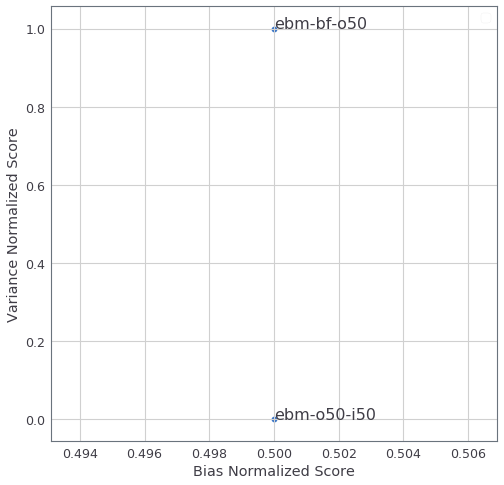

In [58]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(8, 8))
x, y, model_names = bias_ns.loc['average'], var_ns.loc['average'], bias_ns.loc['average'].index
colors = cm.rainbow(np.linspace(0, 1, len(x)))

ax.scatter(x, y)
# for x1, y1, c, model_name in zip(x, y, colors, model_names):
#     plt.scatter(x1, y1, color=c, label=model_name)

for i, txt in enumerate(model_names):
    ax.annotate(txt, (x[i], y[i]), size=16)

plt.legend()
plt.xlabel('Bias Normalized Score')
plt.ylabel('Variance Normalized Score')

In [61]:
model_names

ebm-bf-o50     0.5
ebm-o50-i50    0.5
Name: average, dtype: object

No handles with labels found to put in legend.


Text(0, 0.5, 'Variance Rank')

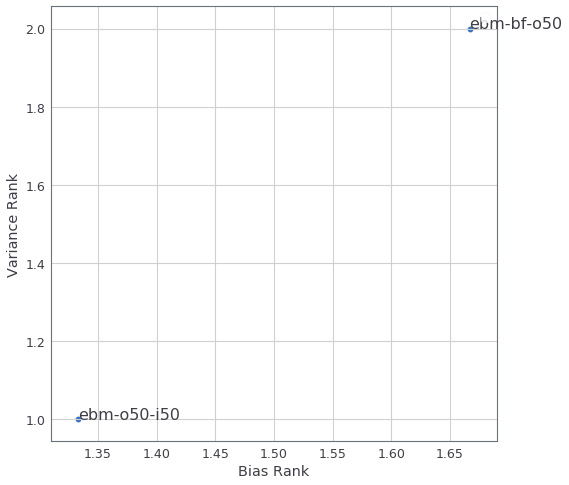

In [62]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(8, 8))
x, y, model_names = bias_rank.loc['average'], var_rank.loc['average'], bias_ns.loc['average'].index
colors = cm.rainbow(np.linspace(0, 1, len(x)))

ax.scatter(x, y)

for i, txt in enumerate(model_names):
    ax.annotate(txt, (x[i], y[i]), size=16)

plt.legend()
plt.xlabel('Bias Rank')
plt.ylabel('Variance Rank')

### BIas/Var Graph

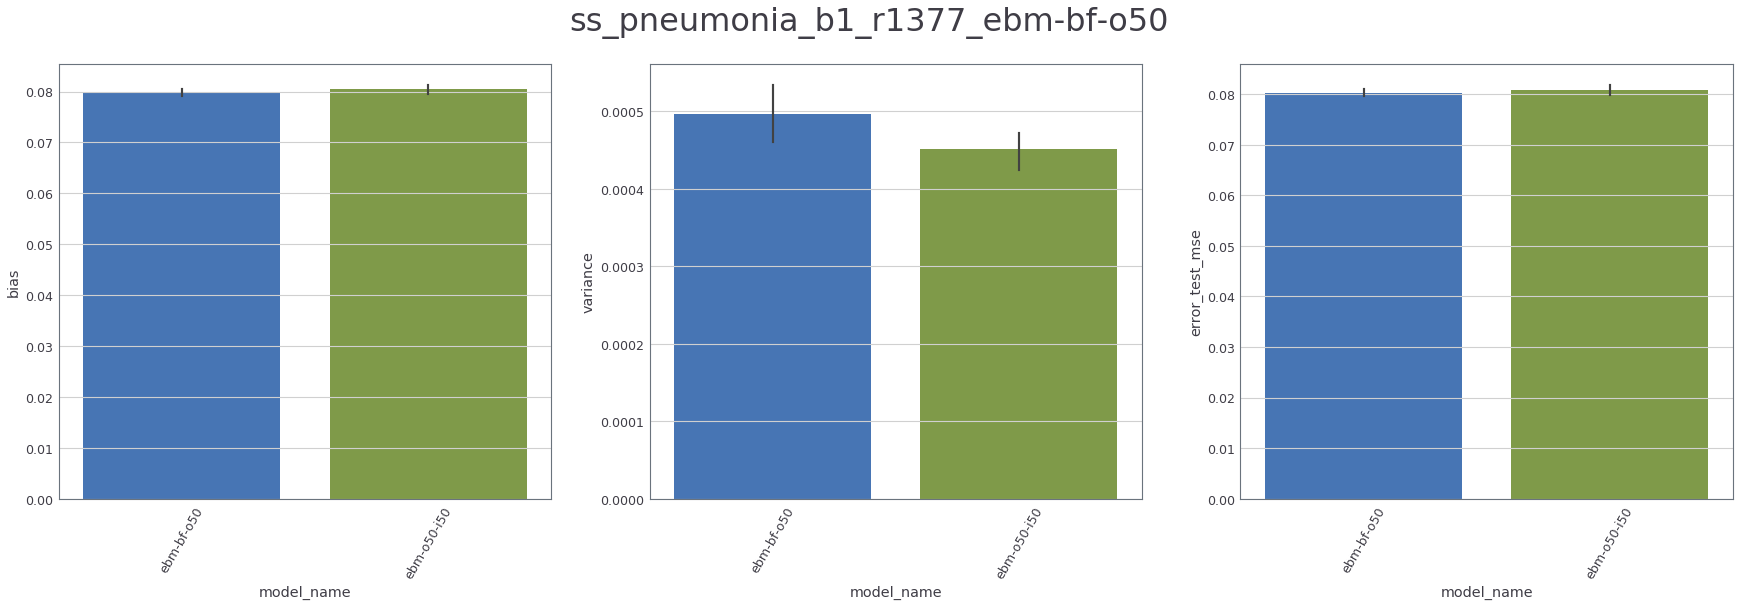

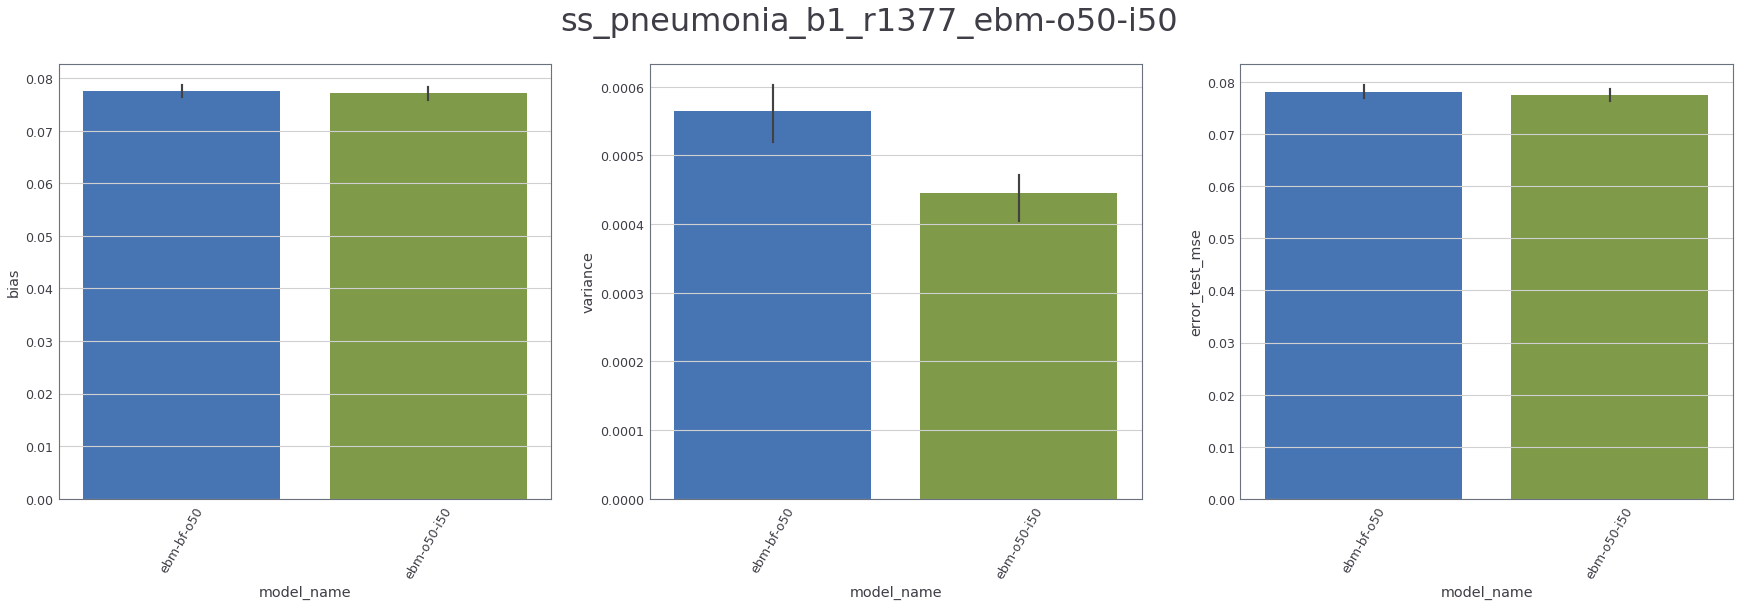

In [ ]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'bagging-100', 'rf-1000', 'xgb-d1', 'xgb-d3', 'ebm-main', 'ebm-pair']

for name, group in cls_record_df.groupby('d_name'):
    group = group.sort_values('model_name')
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))
    
#     if name == 'bikeshare':
#         group = group[group.model_name.apply(lambda x: x != 'mlr')]
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)
    
#     second_highest = np.mean(group.variance.values)
#     axes[1].set_ylim(0., second_highest + 0.6 * second_highest)
    
    sns.barplot(data=group, x='model_name', y='error_test_mse', ax=axes[2], order=order)
#     sns.barplot(data=group, x='model_name', y='avg_test_auc', ax=axes[3], order=order)
#     axes[3].set_ylim(group.avg_test_auc.min() - 0.05, 1.)
    
    for ax in axes:
        for tick in ax.get_xticklabels():
            tick.set_rotation(60)
        
    fig.suptitle(name, fontsize=32)
    plt.show()

### Combined Bias/Var graph

In [23]:
%matplotlibtlib inline

UsageError: Line magic function `%matplotlibtlib` not found.


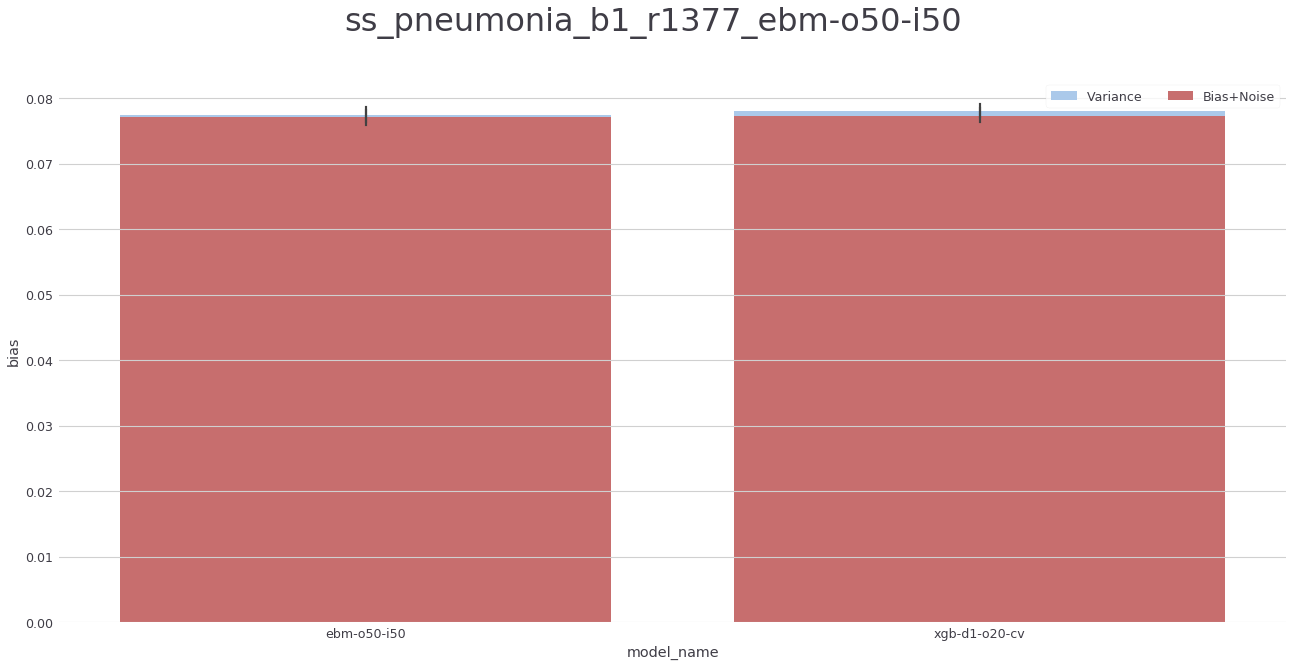

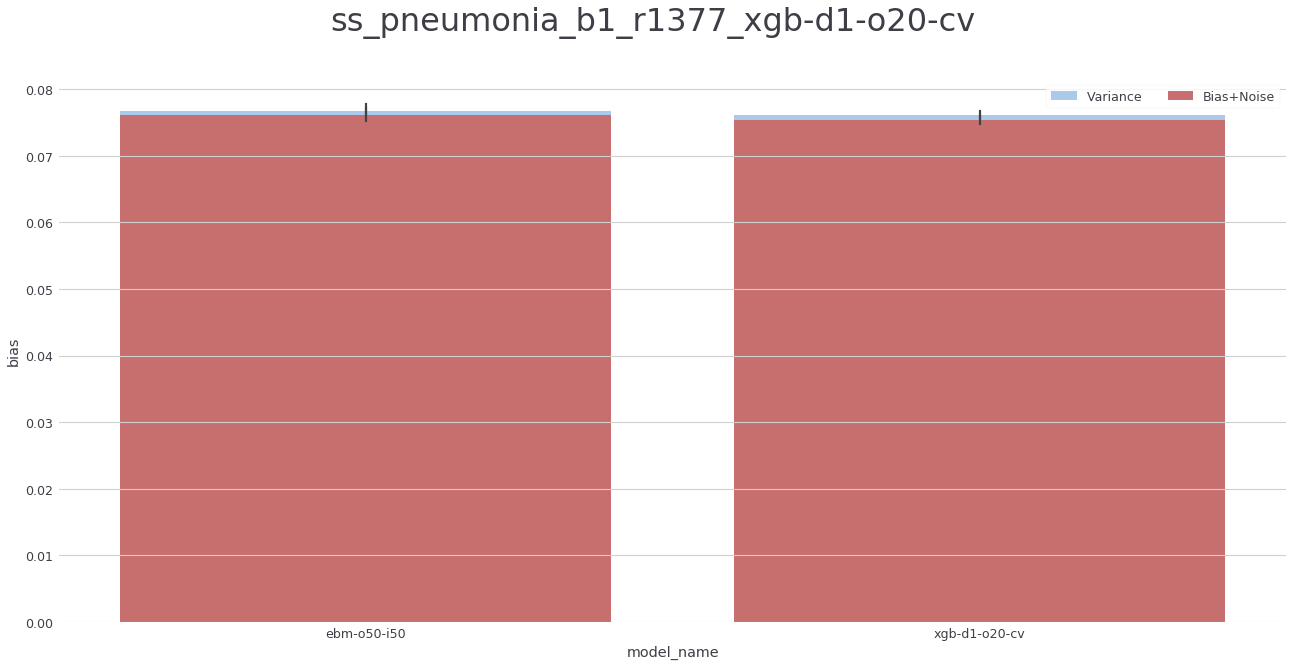

In [24]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'dt', 'bagging-100', 'rf-10', 'rf-1000', 'xgb-d1', 'xgb-d2', 'xgb-d3', 'ebm-main', 'ebm-pair']
# order = ['lr', 'dt', 'bagging-100', 'rf-1000-d5', 'rf-1000-d10', 'rf-1000', 'xgb-d3', 'ebm-main', 'ebm-pair']

for name, group in cls_record_df.sort_values('model_name').groupby('d_name'):
    fig, ax = plt.subplots(figsize=(22, 10))

    sns.set_color_codes("pastel")
    sns.barplot(x="model_name", y="error_test_mse", data=group,
                label="Variance", color="b", order=order)

    sns.set_color_codes("muted")
    sns.barplot(x="model_name", y="bias", data=group,
                label="Bias+Noise", color="r", order=order)

    ax.legend(ncol=2, loc="best", frameon=True)

    sns.despine(left=True, bottom=True)

    fig.suptitle(name, fontsize=32)
    plt.show()

# OLD

In [115]:
record_df = record_df[record_df.d_name != 'credit']

In [116]:
record_df.to_csv('results/bias_var_tradeoff.csv', header=None)

In [117]:
avg_prob_x = record_df.groupby(['d_name', 'model_name', 'split_idx']).test_prob.apply(lambda x: np.mean(x))
avg_prob_x.name = 'avg_prob_x'

record_df = record_df.merge(avg_prob_x, on=['d_name', 'model_name', 'split_idx'], how='outer')

variance = record_df.groupby(['d_name', 'model_name', 'split_idx']).test_prob.apply(lambda x: np.mean(np.var(np.array(x), axis=0)))
variance.name = 'variance'

record_df = record_df.merge(variance, on=['d_name', 'model_name', 'split_idx'], how='outer')

record_df['bias'] = record_df.apply(lambda x: np.mean((x.avg_prob_x - x.y_test.values) ** 2), axis=1)
# record_df['variance'] = record_df.apply(lambda x: np.sum((x.test_prob) ** 2), axis=1)
record_df['error'] = record_df.apply(lambda x: np.mean((x.test_prob - x.y_test.values) ** 2), axis=1)

record_df['auroc'] = record_df.apply(lambda x: roc_auc_score(x.y_test.values.astype(int), x.test_prob), axis=1)

record_df.head()

,d_name,fit_time,model_name,split_idx,sub_idx,test_prob,y_test,avg_prob_x,variance,bias,error,auroc
0,pneumonia,0.1,lr,0,0,"[0.0019403966939916778, 0.13539493725080312, 0...",4983 0 7328 0 7670 0 671 0 4144 ...,"[0.002548400079997235, 0.11486232208483393, 0....",0.000735,0.078689,0.079145,0.835612
1,pneumonia,0.1,lr,0,1,"[0.002235294635898577, 0.12614752926163483, 0....",4983 0 7328 0 7670 0 671 0 4144 ...,"[0.002548400079997235, 0.11486232208483393, 0....",0.000735,0.078689,0.079939,0.831495
2,pneumonia,0.2,lr,0,2,"[0.0023599269247155464, 0.10333131668972878, 0...",4983 0 7328 0 7670 0 671 0 4144 ...,"[0.002548400079997235, 0.11486232208483393, 0....",0.000735,0.078689,0.079473,0.825405
3,pneumonia,0.1,lr,0,3,"[0.0021084825971422858, 0.12162539400431853, 0...",4983 0 7328 0 7670 0 671 0 4144 ...,"[0.002548400079997235, 0.11486232208483393, 0....",0.000735,0.078689,0.079704,0.827021
4,pneumonia,0.1,lr,0,4,"[0.002733550538891471, 0.12278327387405757, 0....",4983 0 7328 0 7670 0 671 0 4144 ...,"[0.002548400079997235, 0.11486232208483393, 0....",0.000735,0.078689,0.079775,0.832719


In [118]:
summary_df = record_df.groupby(['d_name', 'model_name', 'split_idx'])['variance'].apply(lambda x: np.mean(x)).reset_index()

summary_df['bias'] = record_df.groupby(['d_name', 'model_name', 'split_idx'])['bias'].apply(lambda x: np.mean(x)).values
summary_df['error'] = record_df.groupby(['d_name', 'model_name', 'split_idx'])['error'].apply(lambda x: np.mean(x)).values
summary_df['auroc'] = record_df.groupby(['d_name', 'model_name', 'split_idx'])['auroc'].apply(lambda x: np.mean(x)).values

In [119]:
summary_df.head()

,d_name,model_name,split_idx,variance,bias,error,auroc
0,adult,ebm-main,0,0.001008,0.095430,0.096437,0.913165
1,adult,ebm-main,1,0.001879,0.094125,0.096003,0.914043
2,adult,ebm-main,2,0.001694,0.092588,0.094282,0.915546
3,adult,ebm-main,3,0.001634,0.094156,0.095789,0.915556
4,adult,ebm-main,4,0.001650,0.093497,0.095147,0.915489


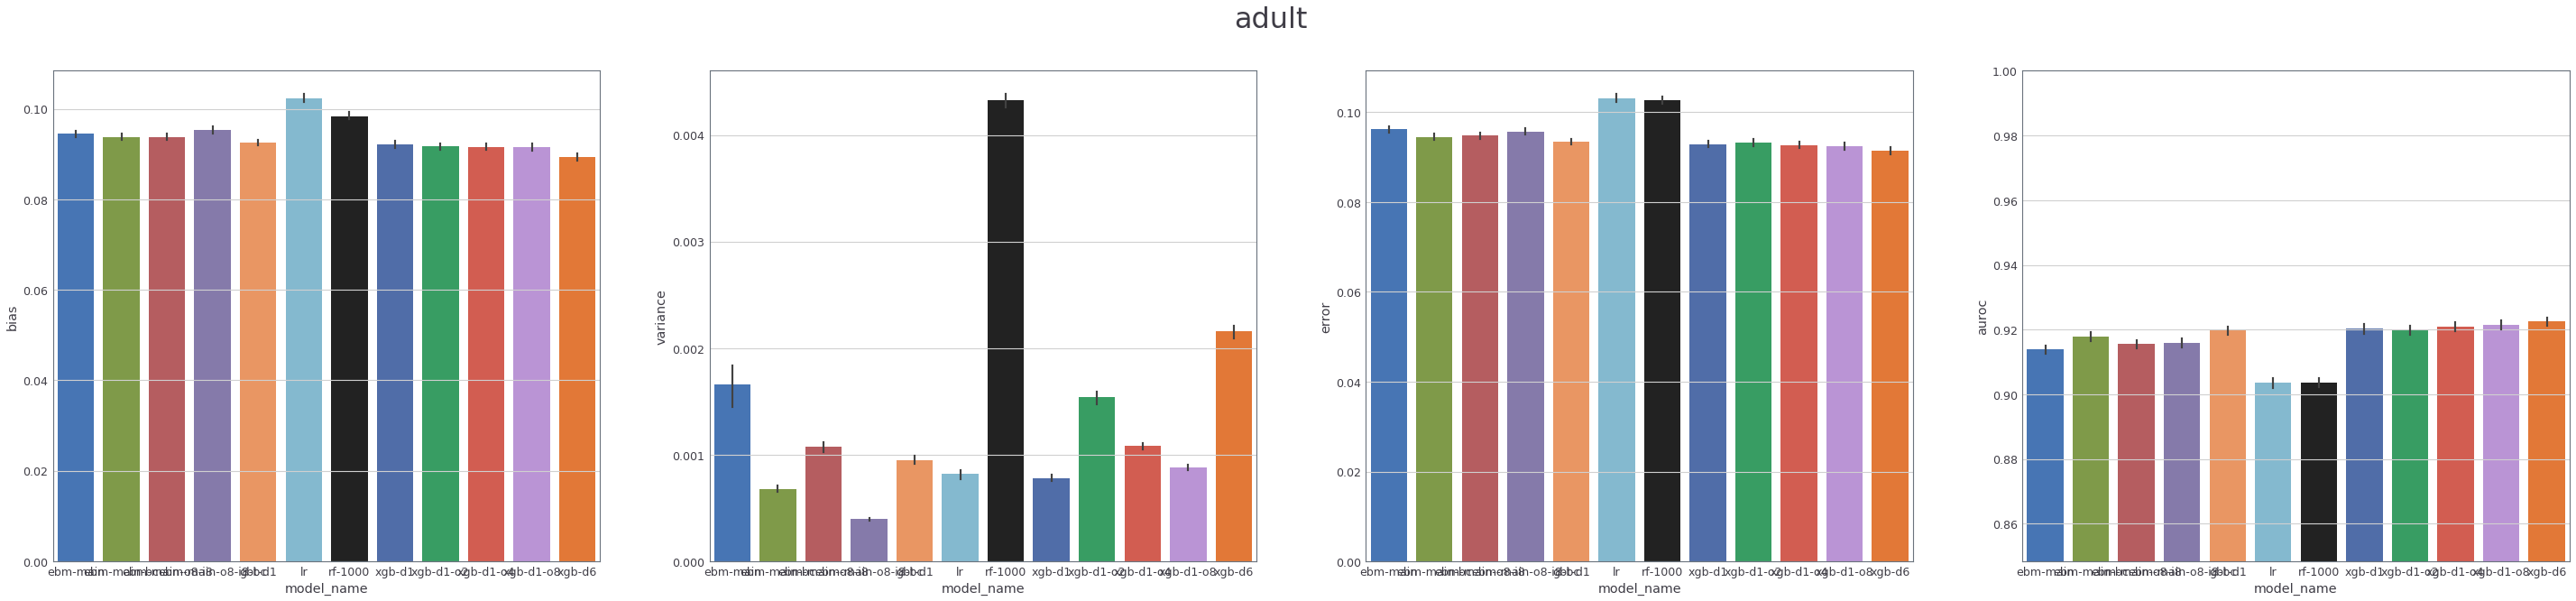

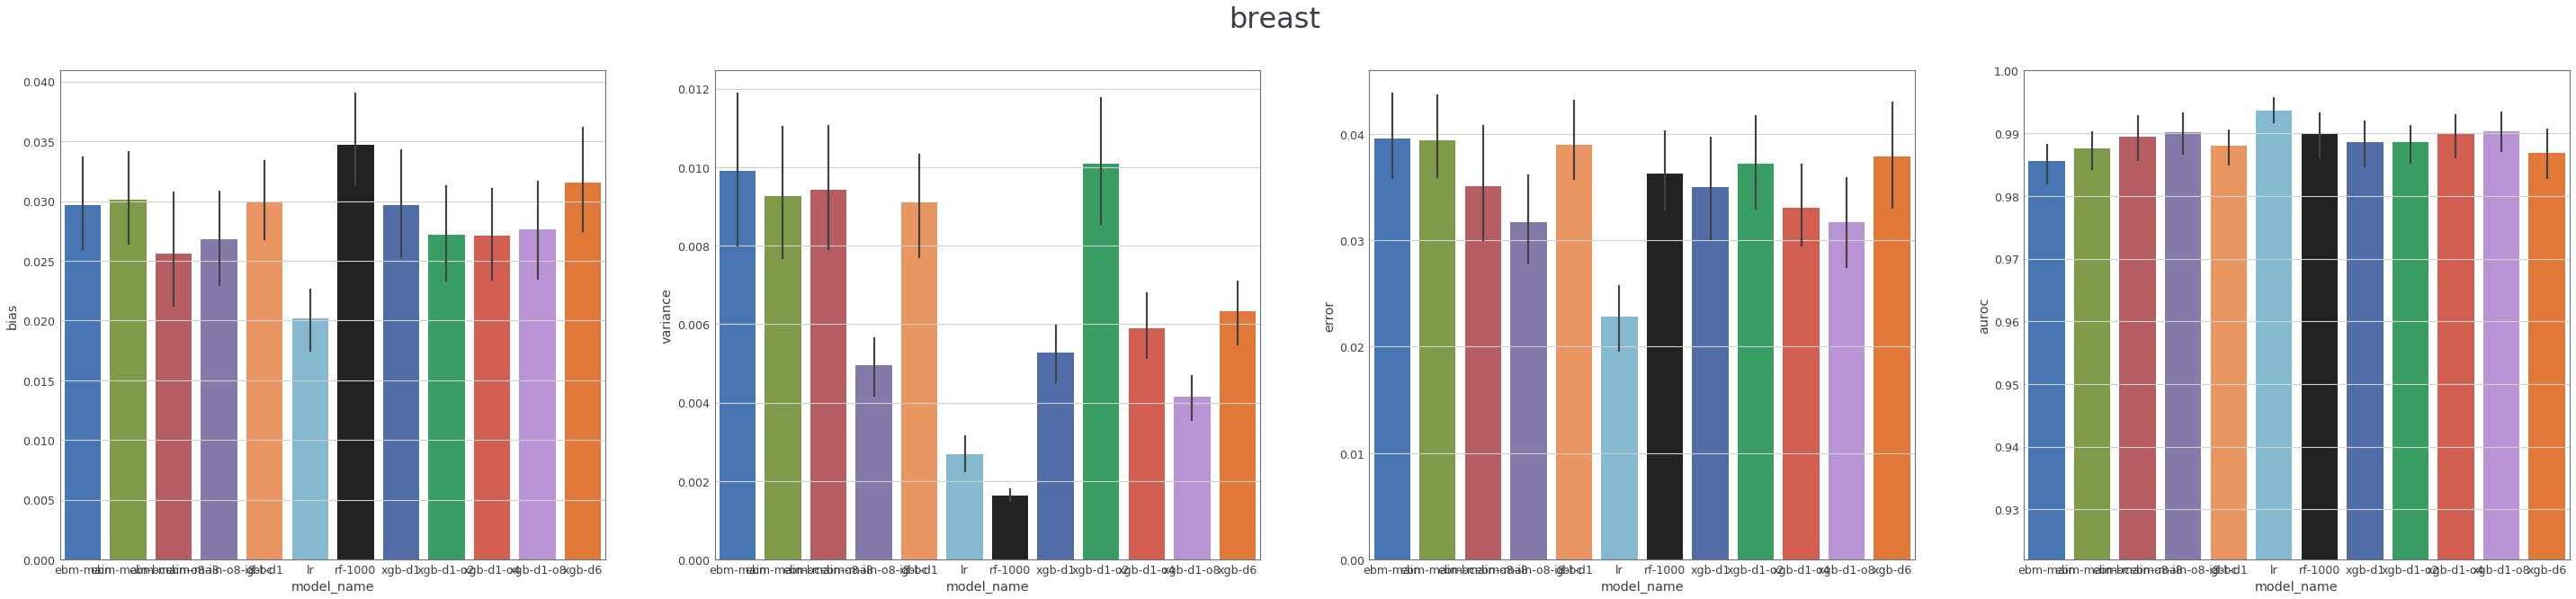

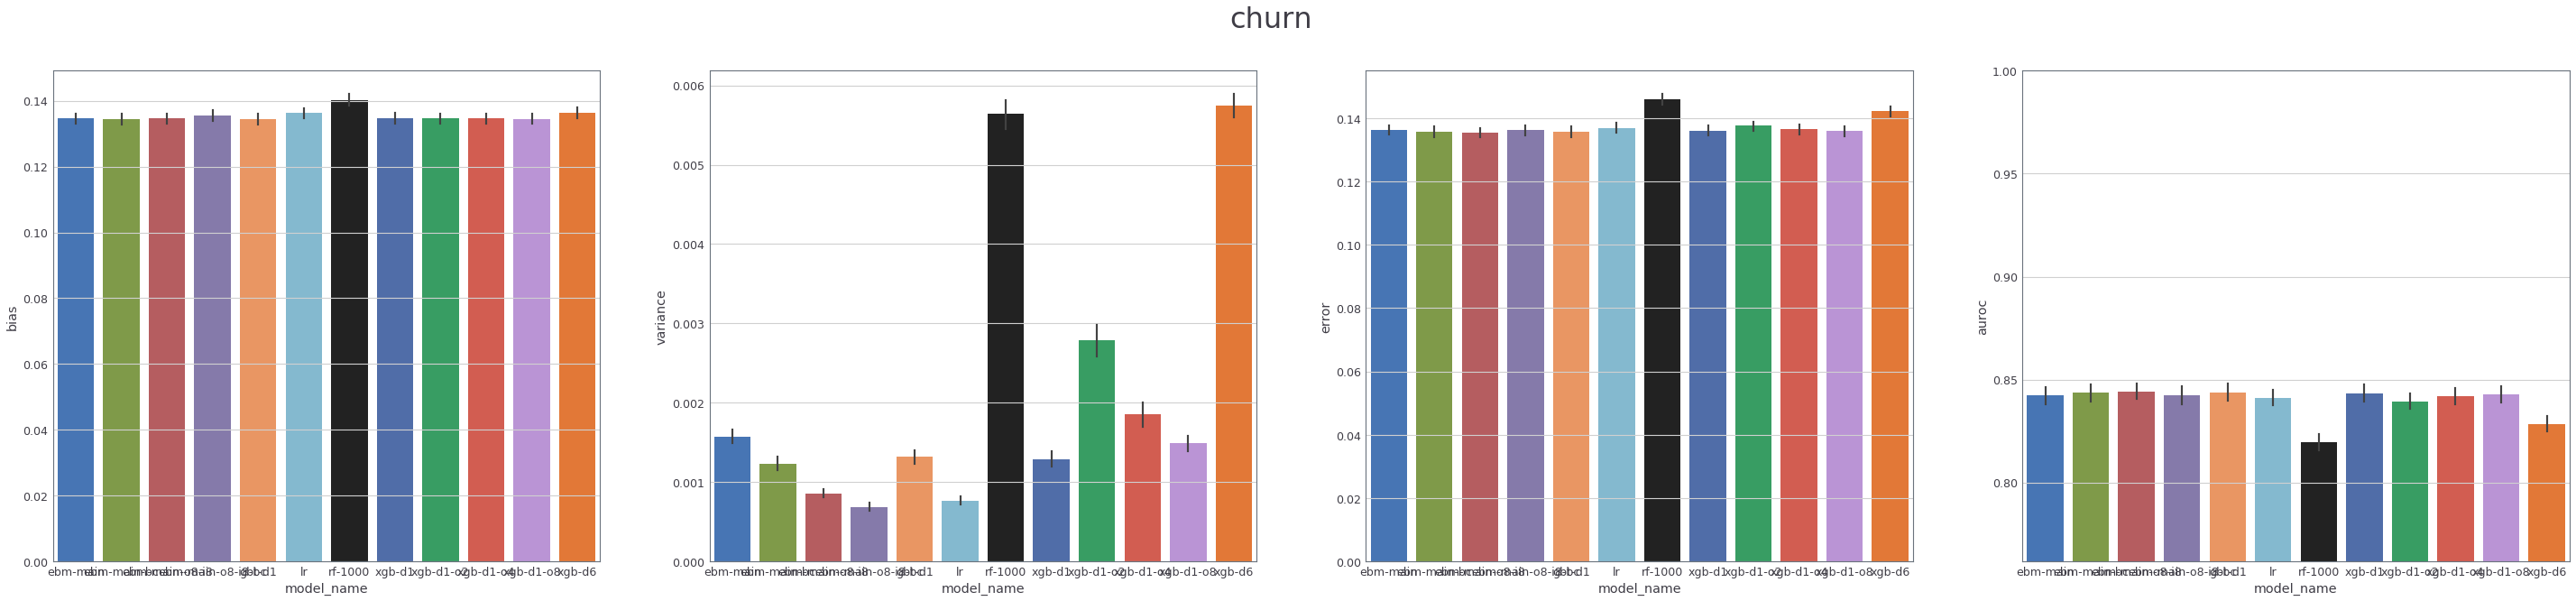

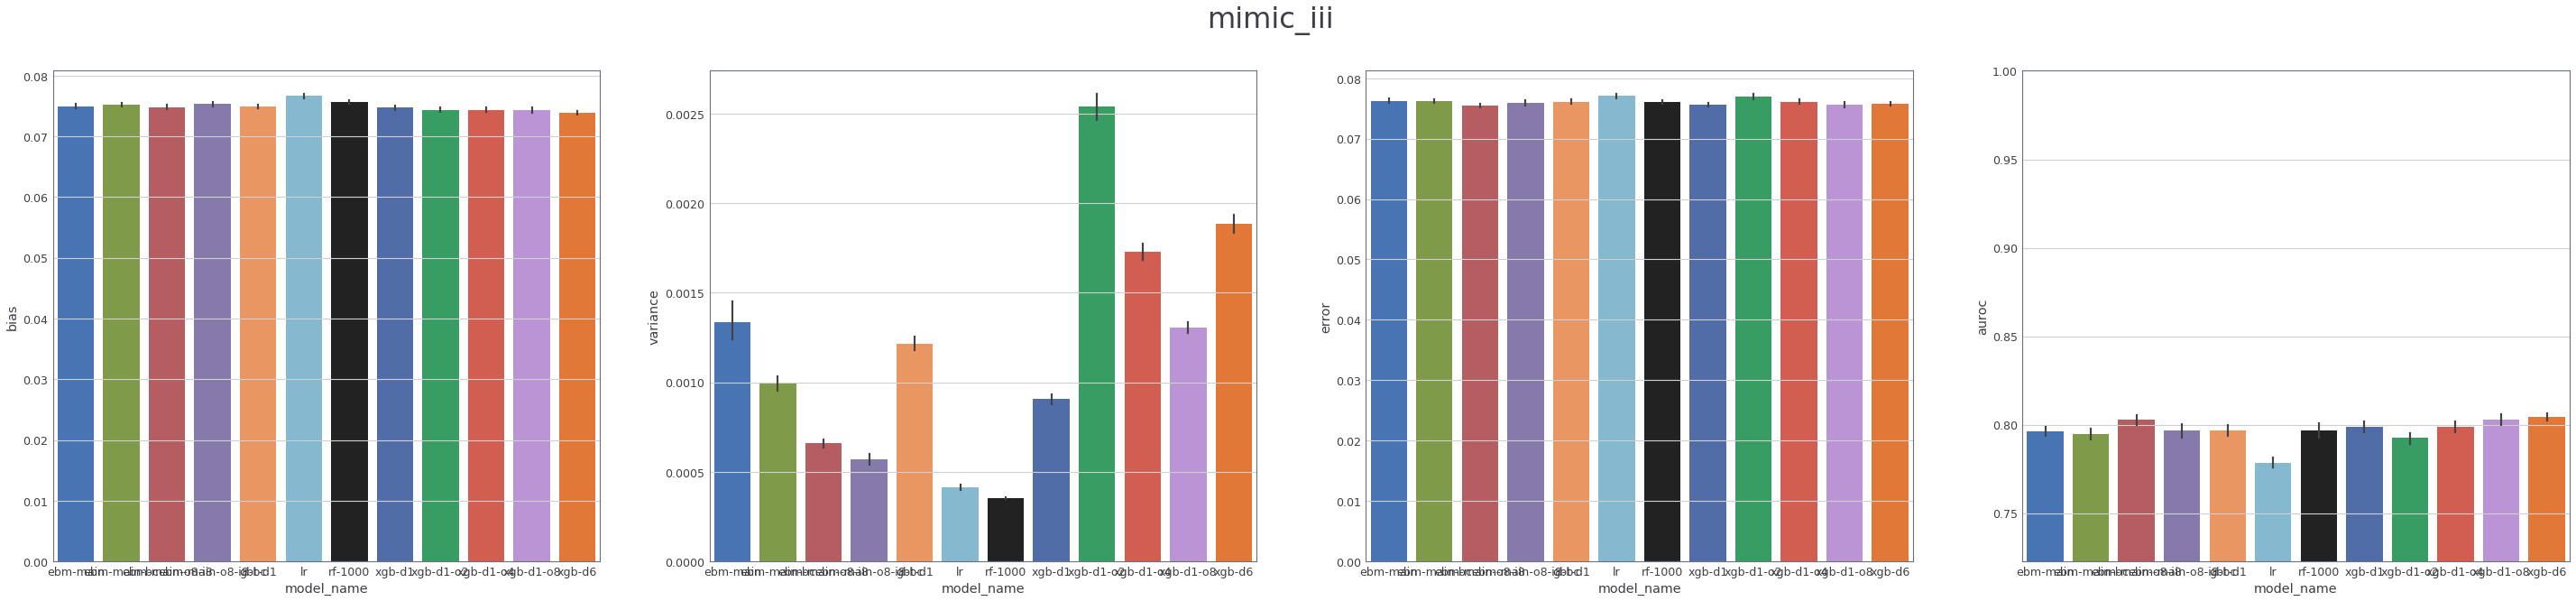

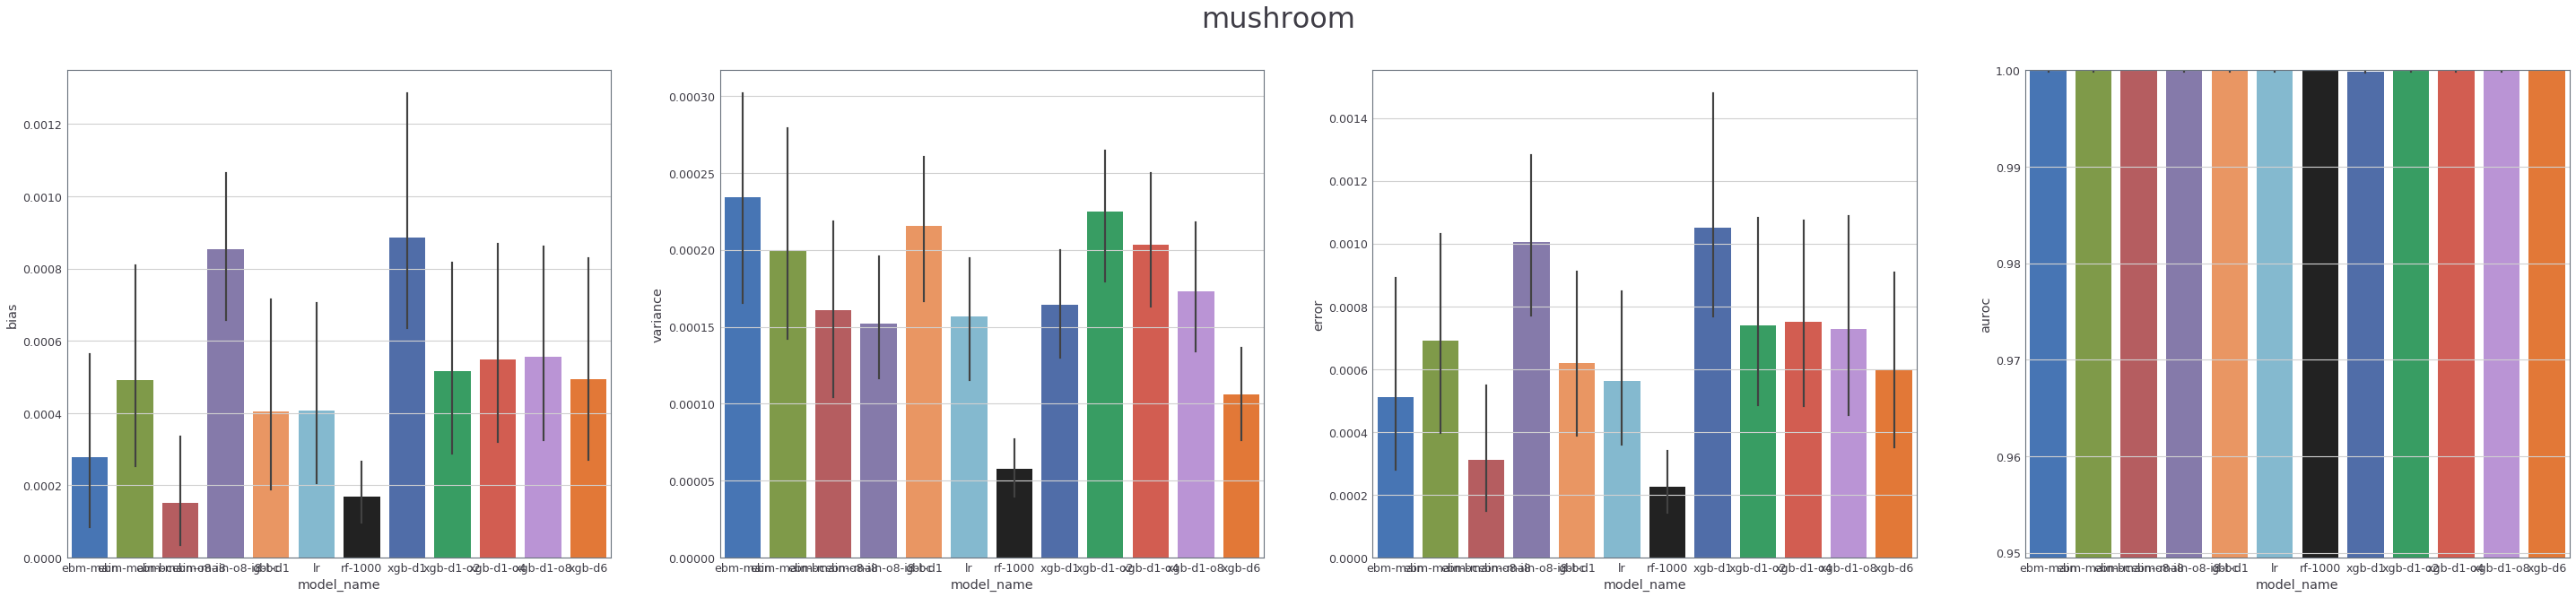

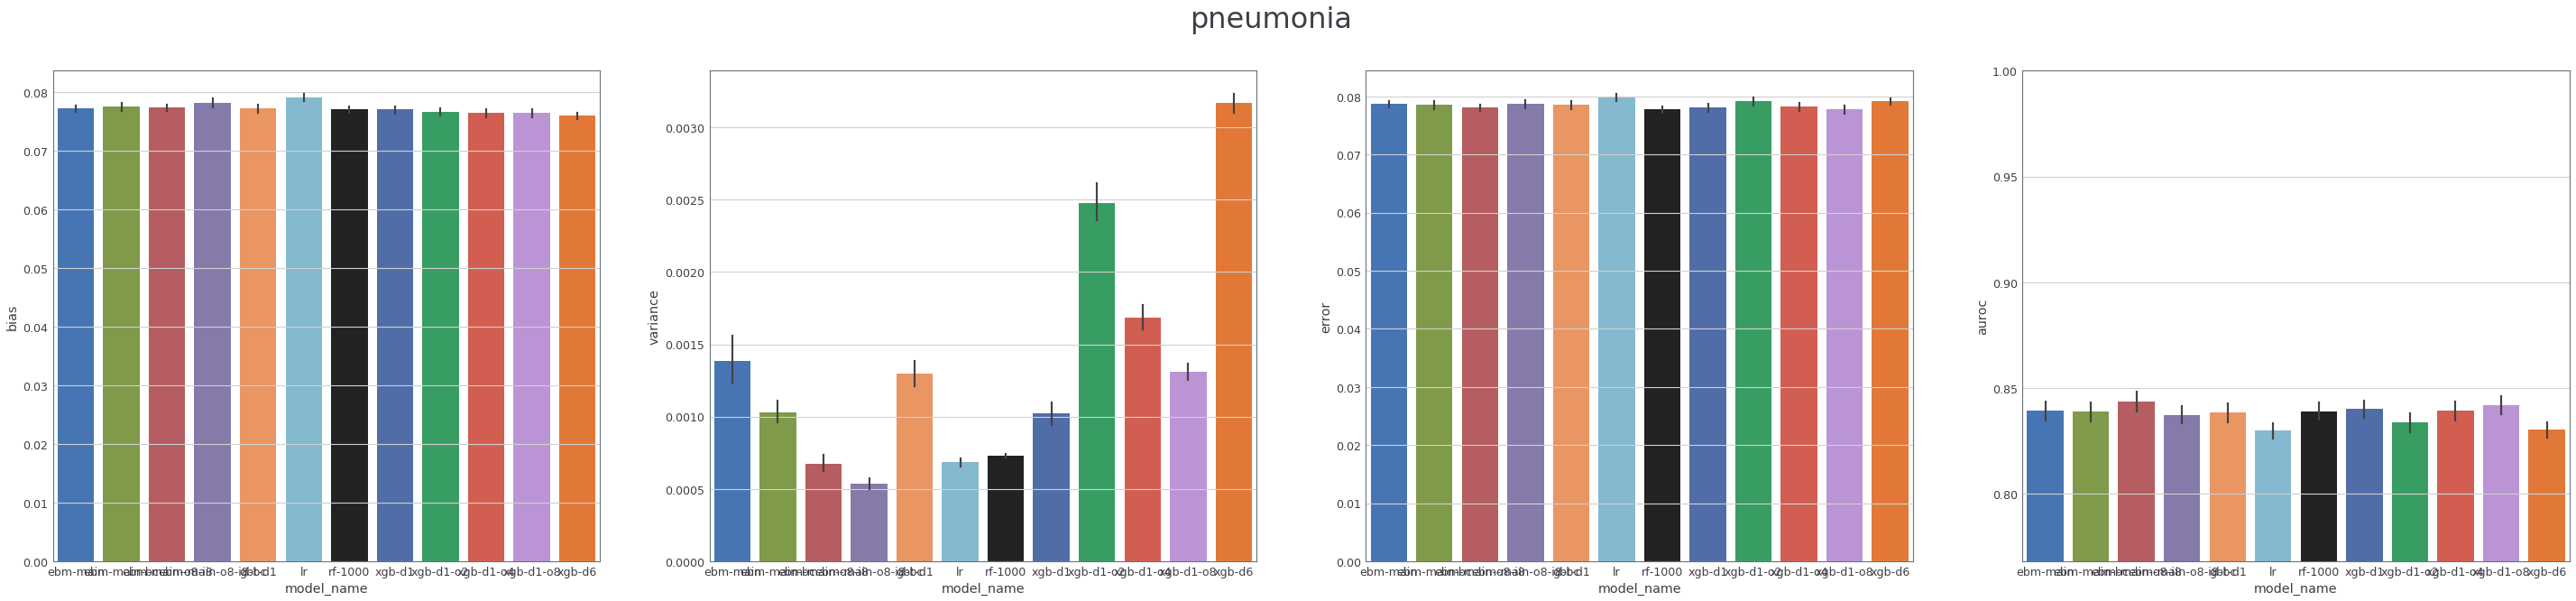

In [120]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'bagging-100', 'rf-1000', 'xgb-d1', 'xgb-d3', 'ebm-main', 'ebm-pair']


for name, group in summary_df.groupby('d_name'):
    fig, axes = plt.subplots(1, 4, figsize=(50, 10))
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)
    
#     second_highest = np.mean(group.variance.values)
#     axes[1].set_ylim(0., second_highest + 0.6 * second_highest)
    
    sns.barplot(data=group, x='model_name', y='error', ax=axes[2], order=order)
    sns.barplot(data=group, x='model_name', y='auroc', ax=axes[3], order=order)
    axes[3].set_ylim(group.auroc.min() - 0.05, 1.)

    fig.suptitle(name, fontsize=32)


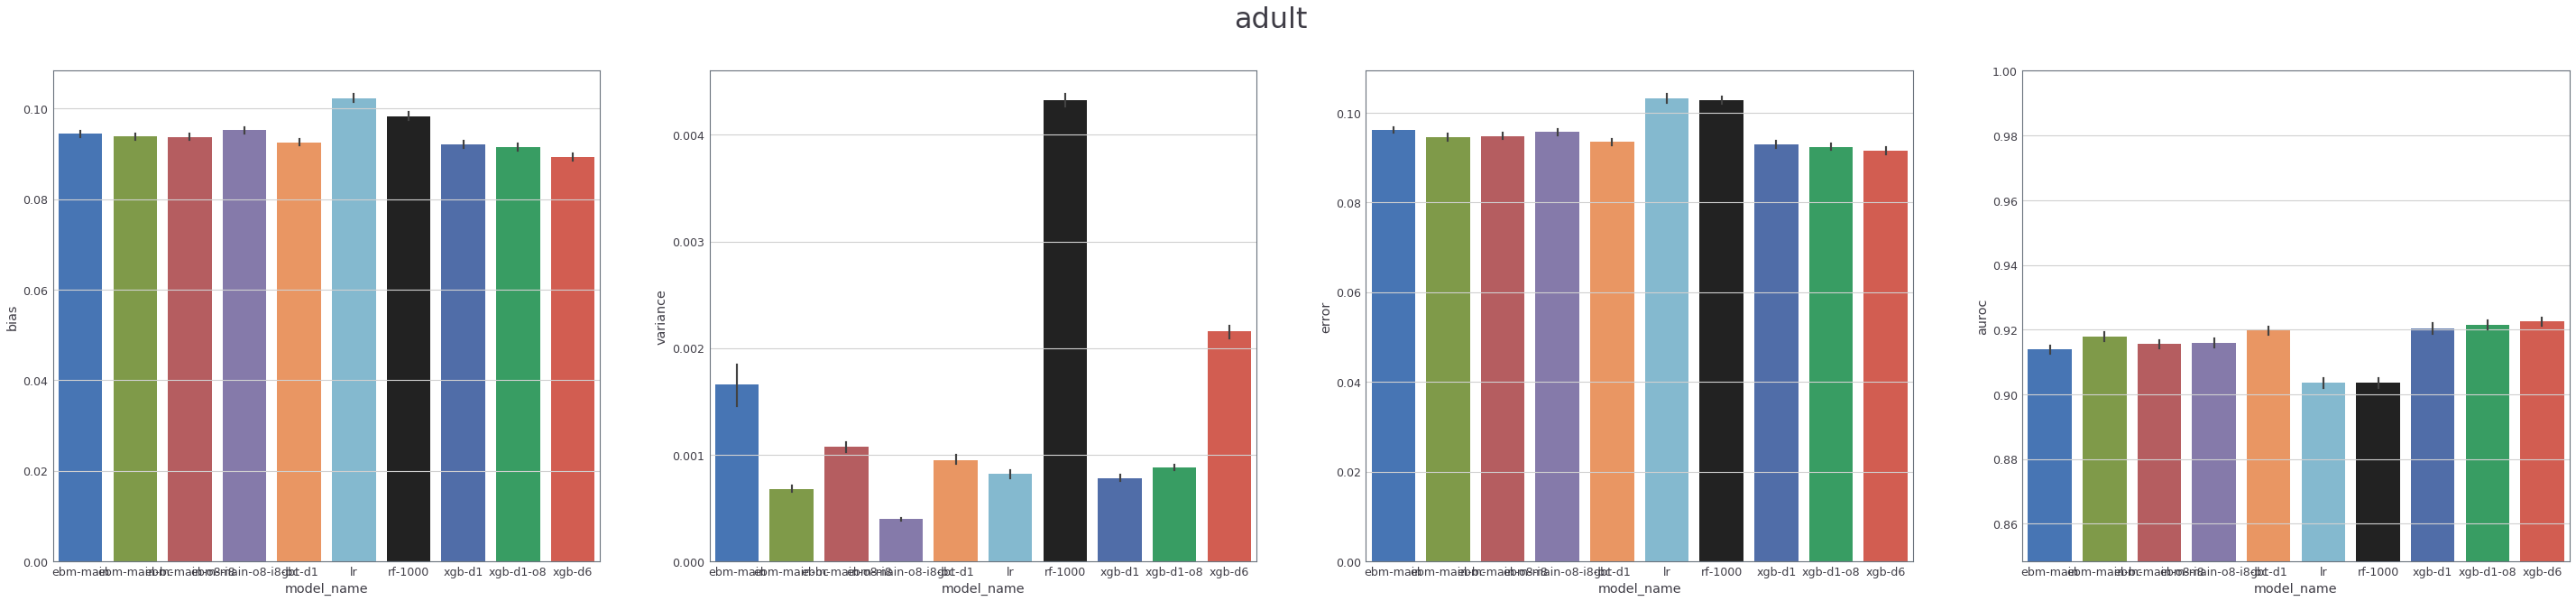

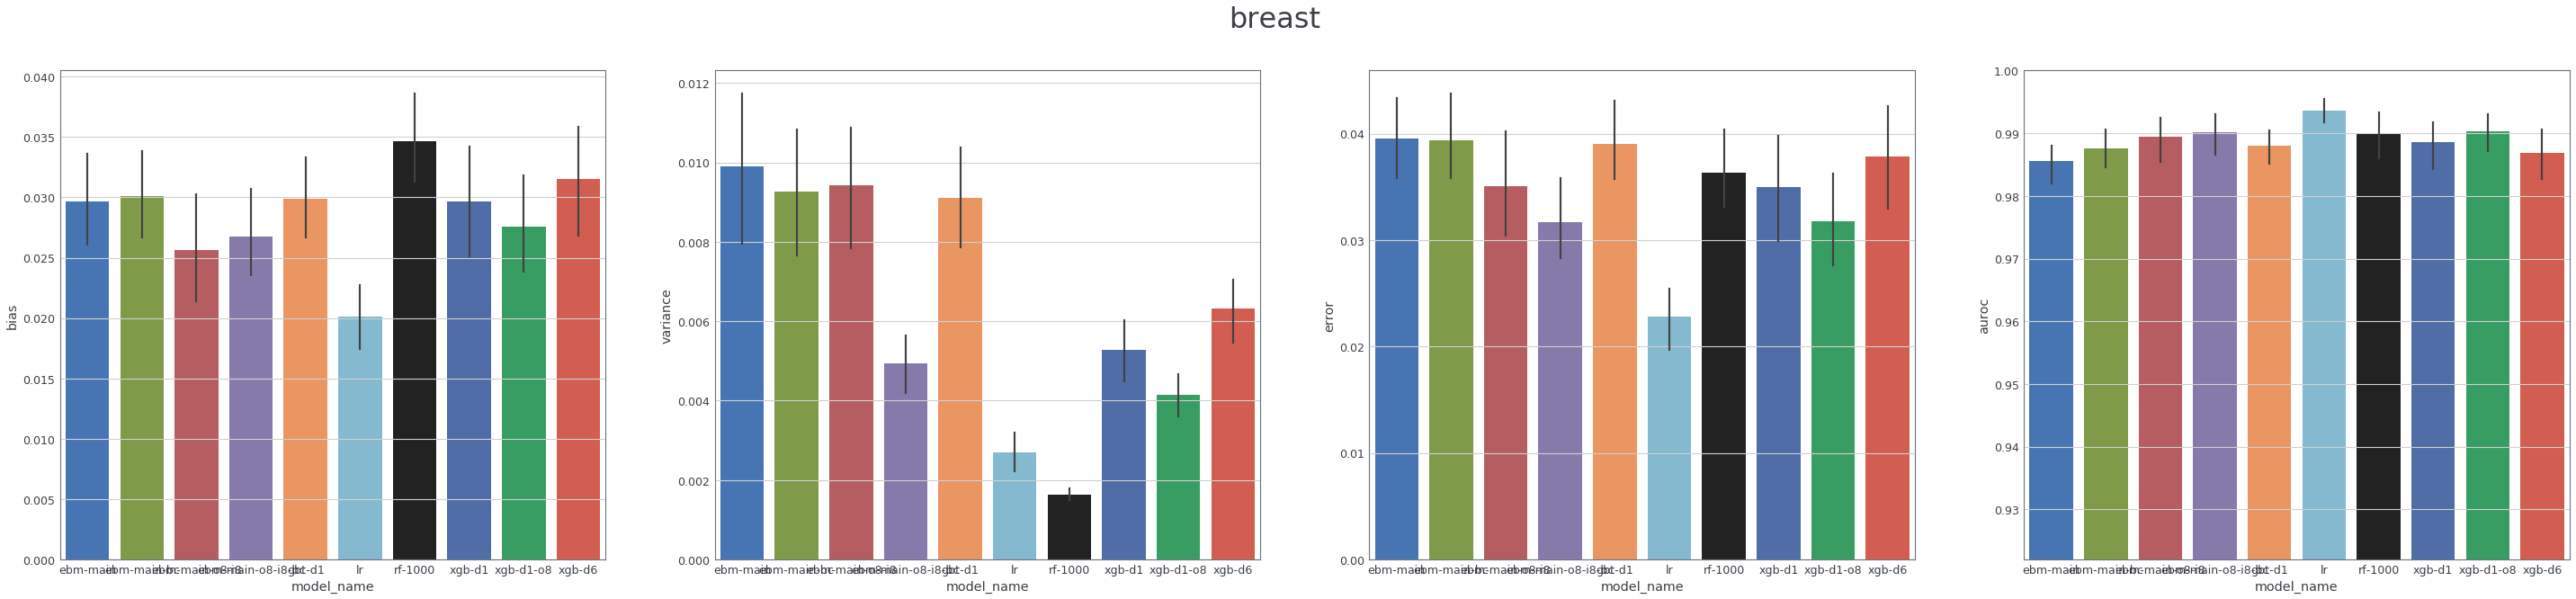

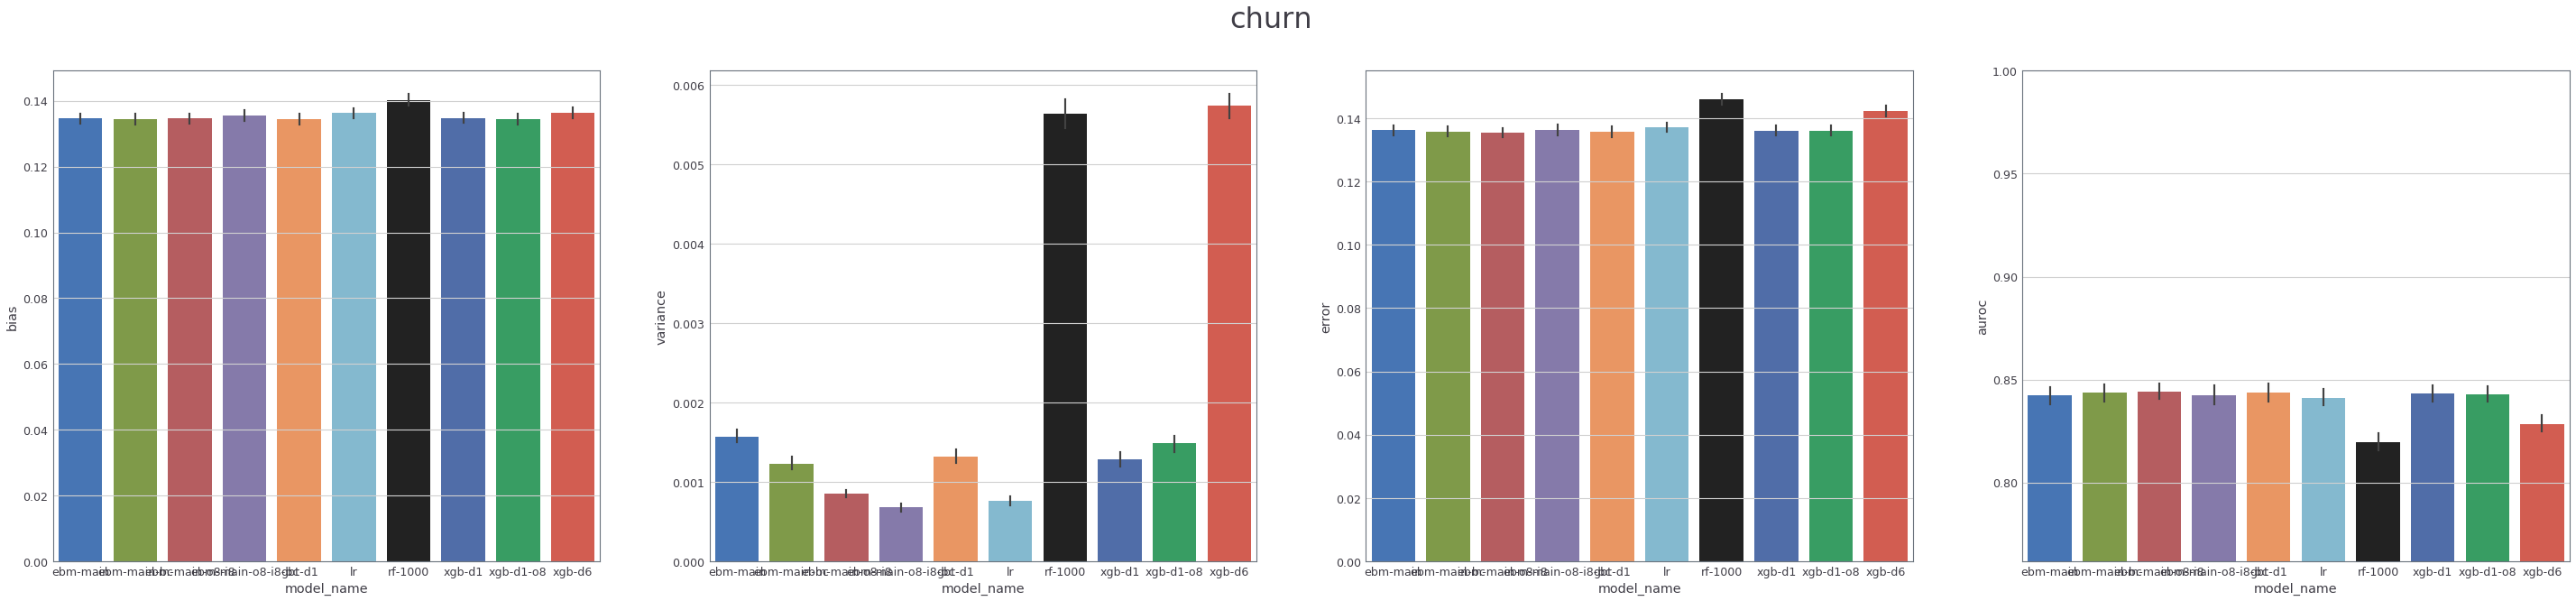

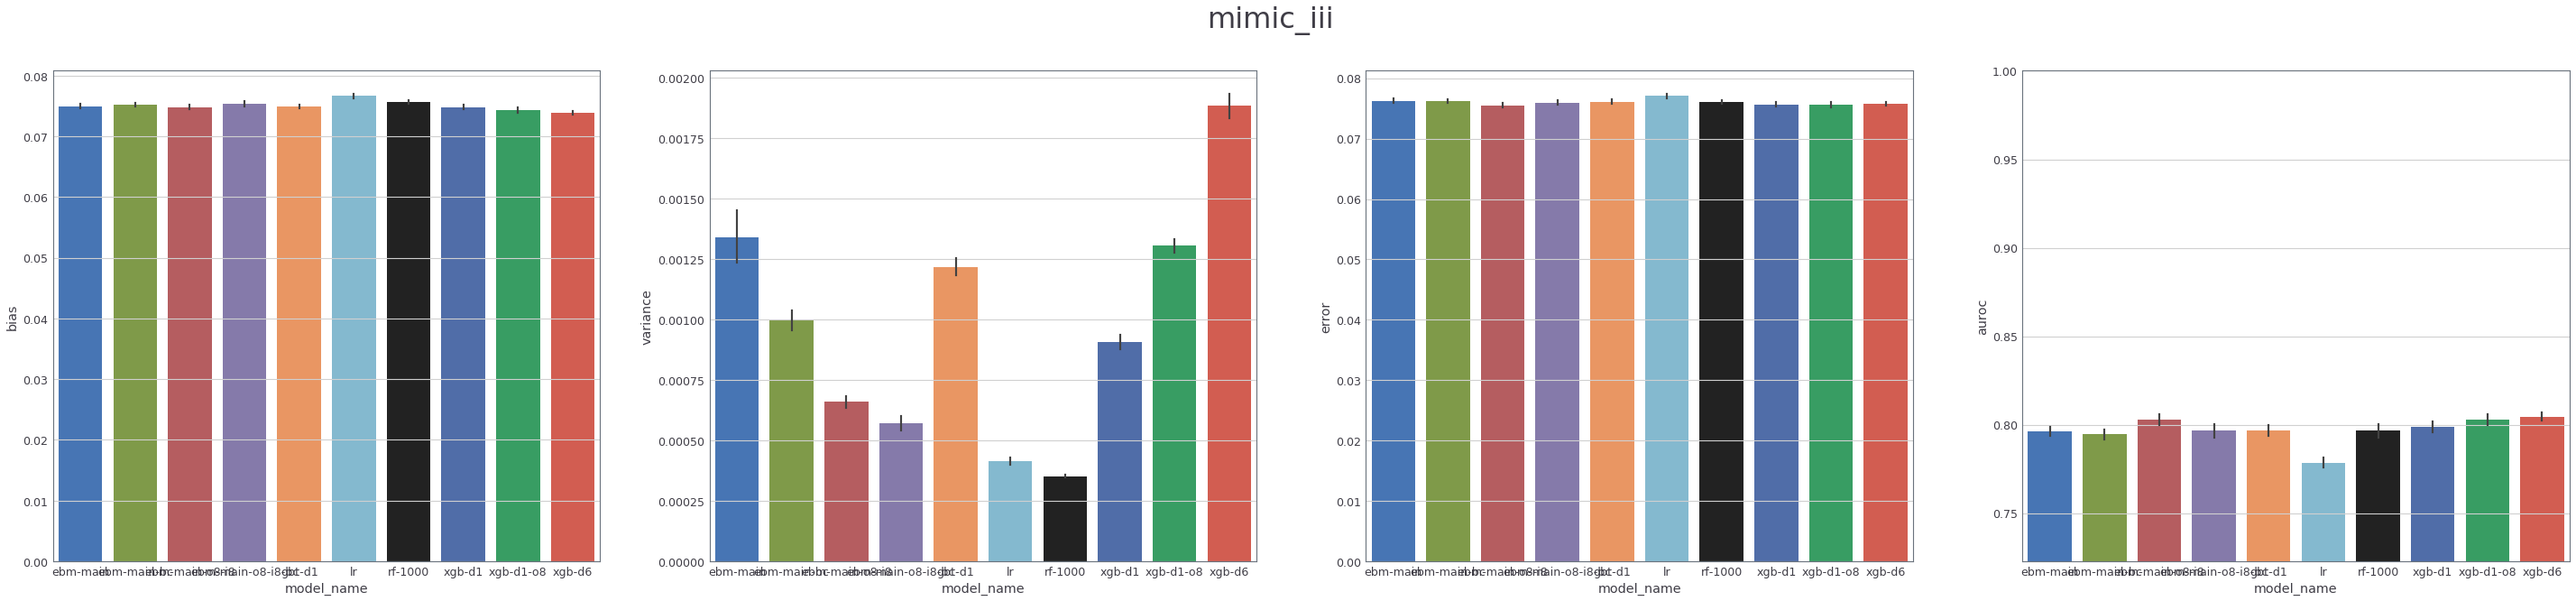

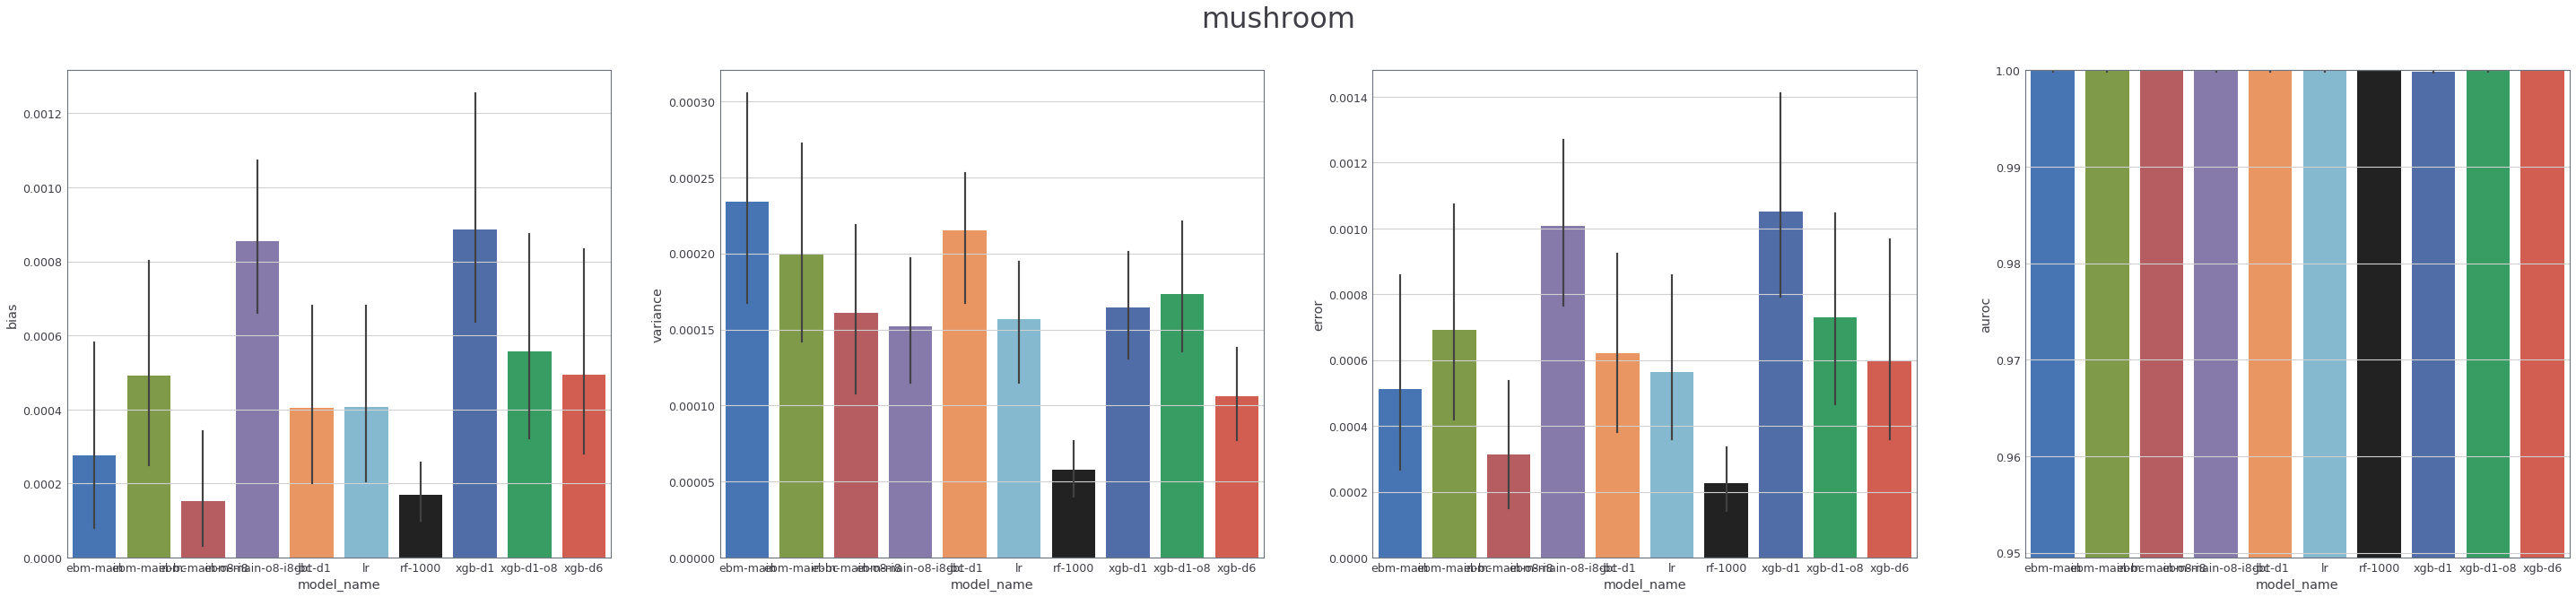

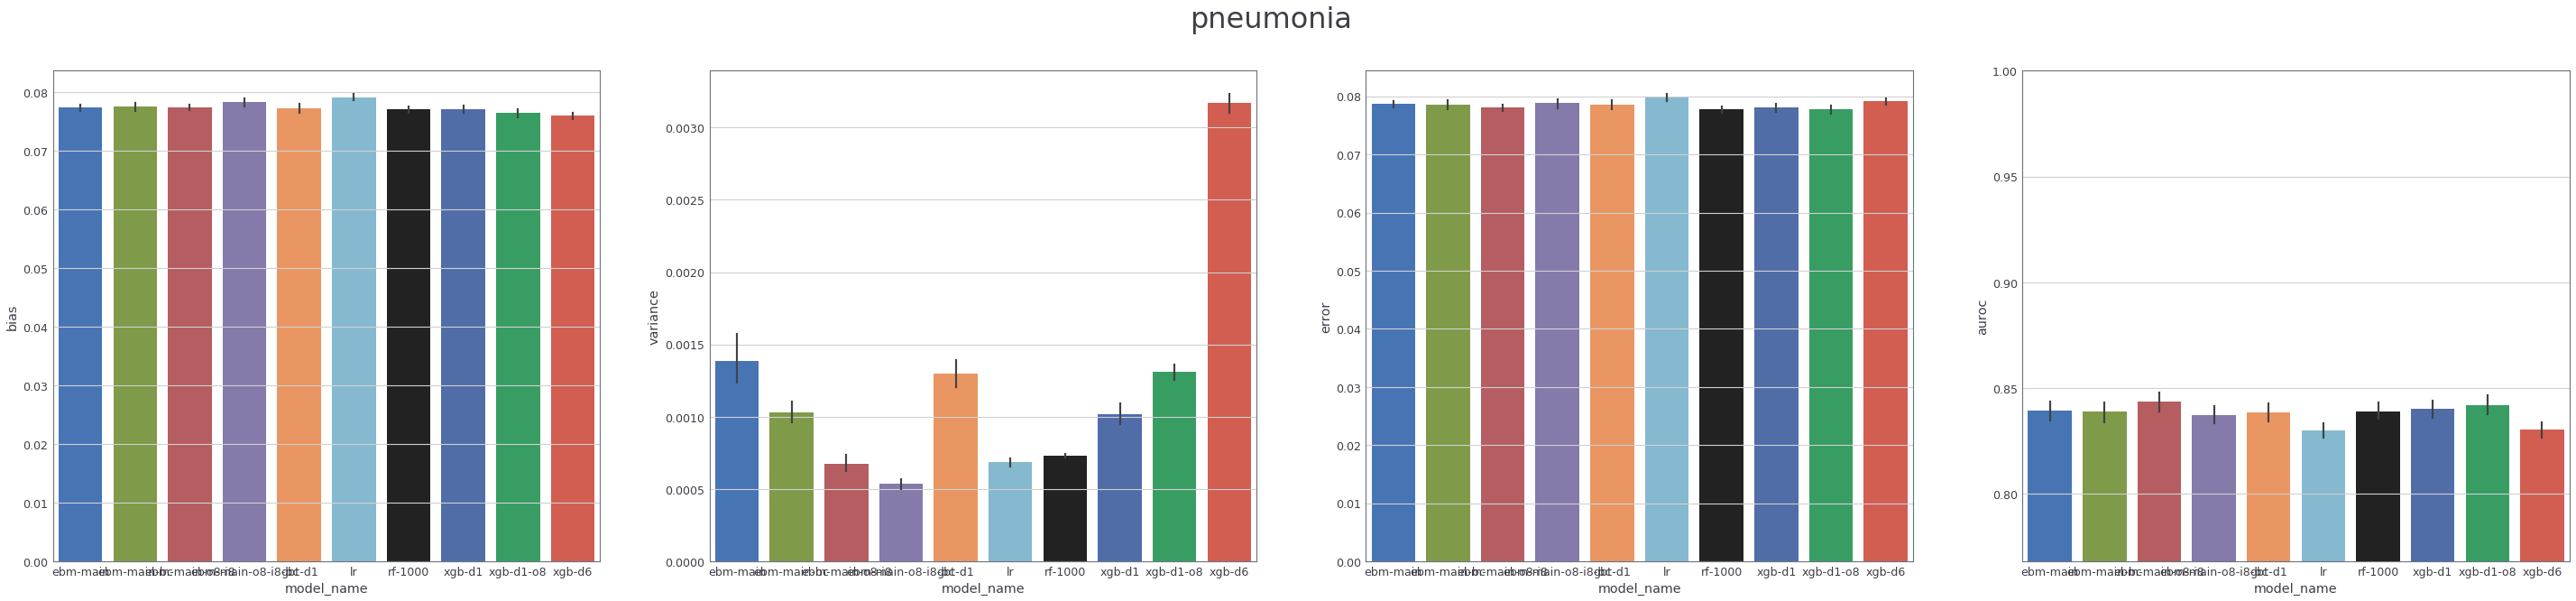

In [104]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'bagging-100', 'rf-1000', 'xgb-d1', 'xgb-d3', 'ebm-main', 'ebm-pair']


for name, group in summary_df.groupby('d_name'):
    fig, axes = plt.subplots(1, 4, figsize=(50, 10))
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)
    
#     second_highest = np.mean(group.variance.values)
#     axes[1].set_ylim(0., second_highest + 0.6 * second_highest)
    
    sns.barplot(data=group, x='model_name', y='error', ax=axes[2], order=order)
    sns.barplot(data=group, x='model_name', y='auroc', ax=axes[3], order=order)
    axes[3].set_ylim(group.auroc.min() - 0.05, 1.)

    fig.suptitle(name, fontsize=32)


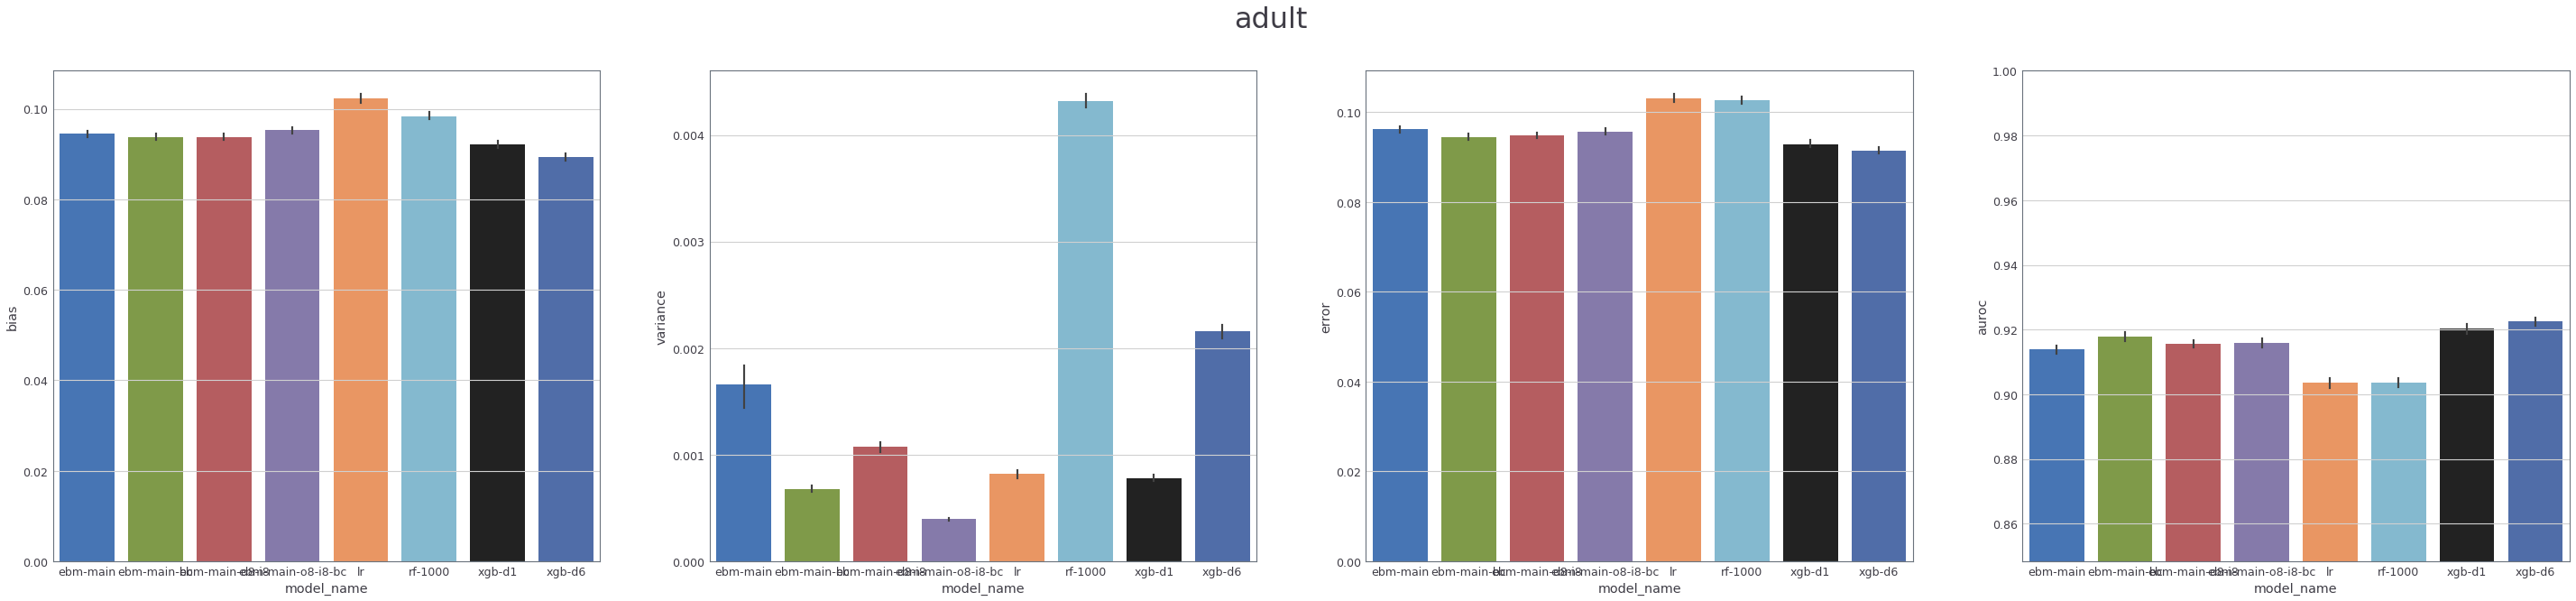

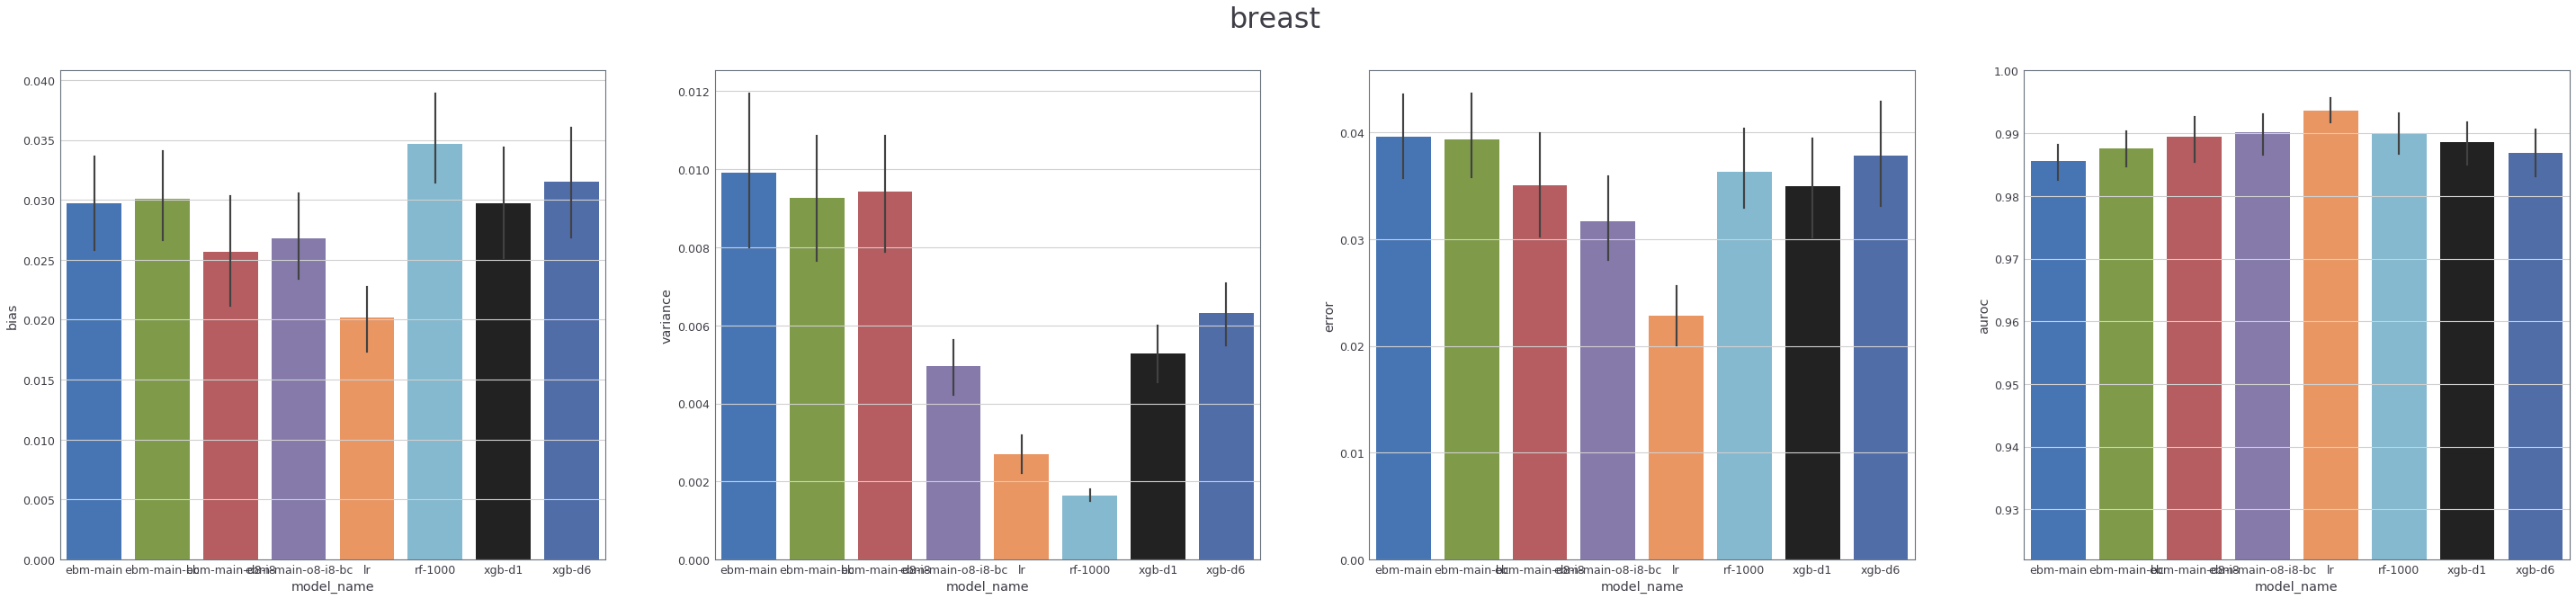

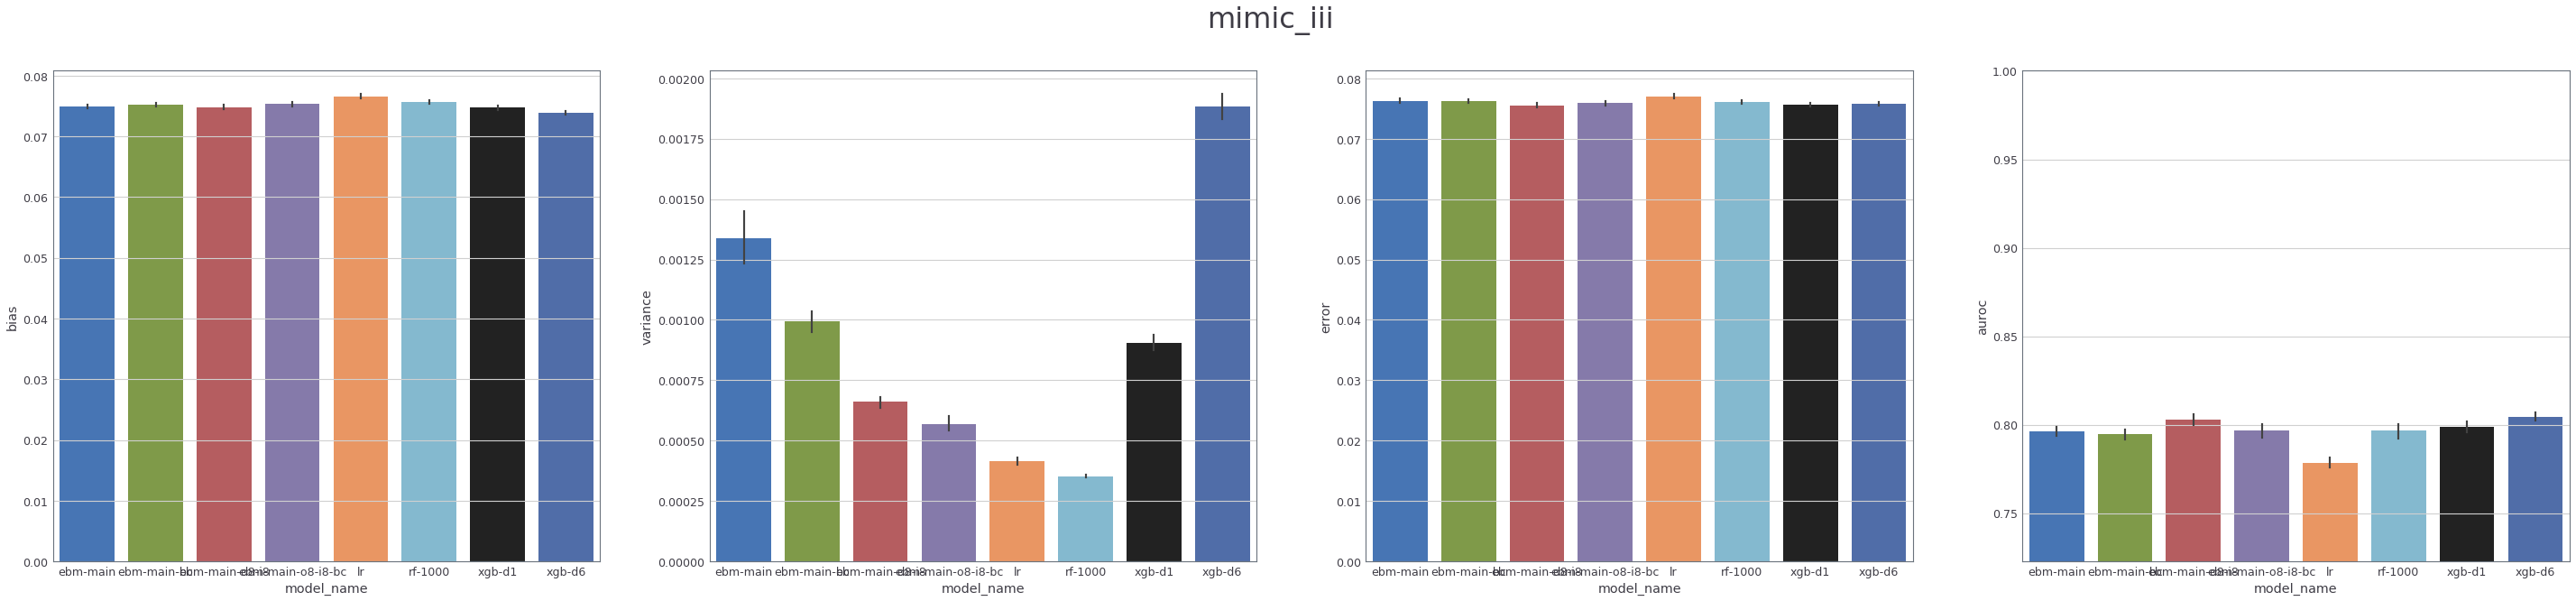

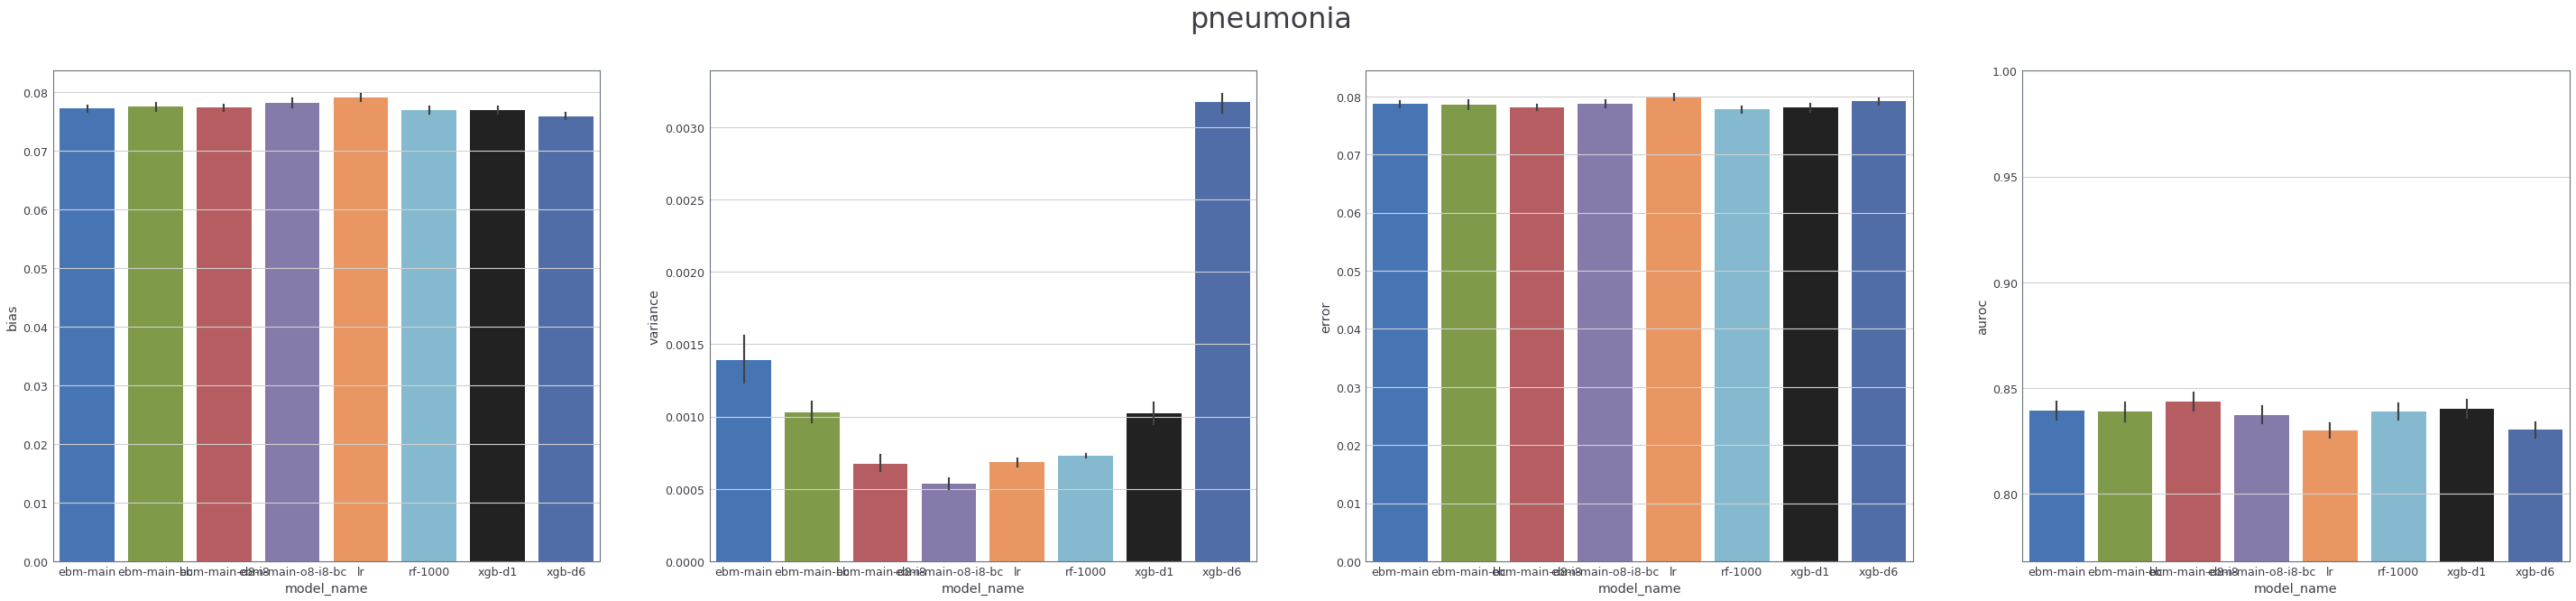

In [22]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'bagging-100', 'rf-1000', 'xgb-d1', 'xgb-d3', 'ebm-main', 'ebm-pair']


for name, group in summary_df.groupby('d_name'):
    fig, axes = plt.subplots(1, 4, figsize=(50, 10))
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)
    
#     second_highest = np.mean(group.variance.values)
#     axes[1].set_ylim(0., second_highest + 0.6 * second_highest)
    
    sns.barplot(data=group, x='model_name', y='error', ax=axes[2], order=order)
    sns.barplot(data=group, x='model_name', y='auroc', ax=axes[3], order=order)
    axes[3].set_ylim(group.auroc.min() - 0.05, 1.)

    fig.suptitle(name, fontsize=32)


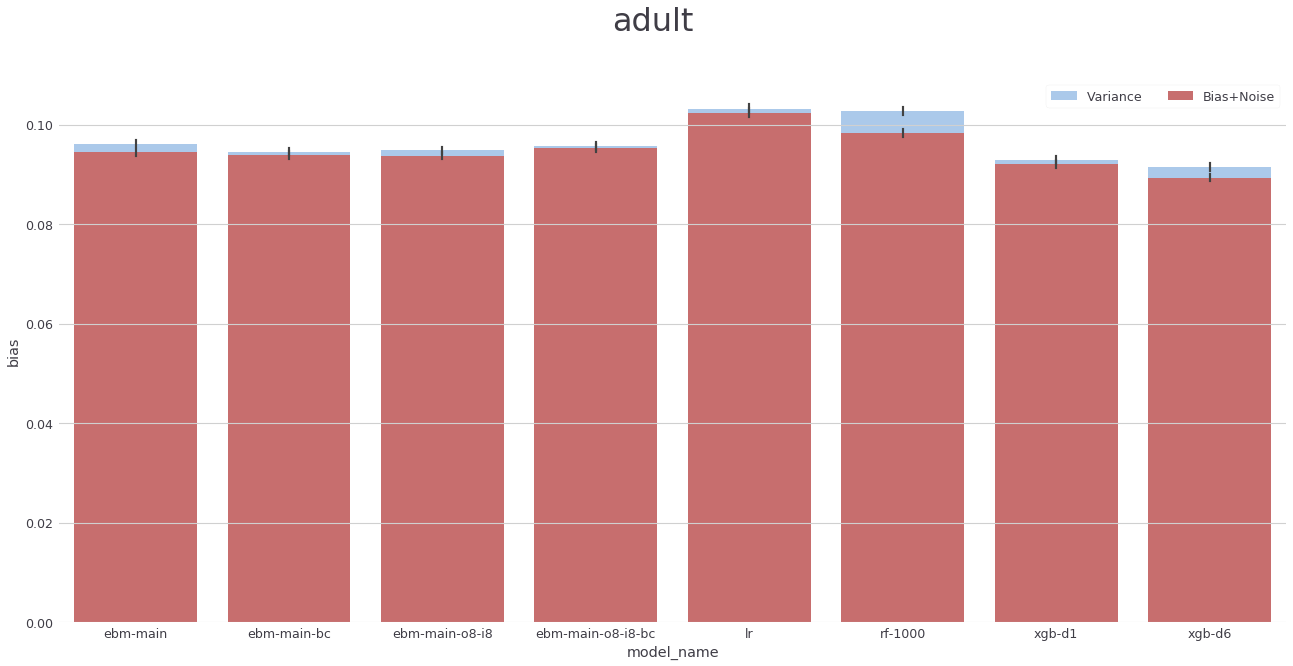

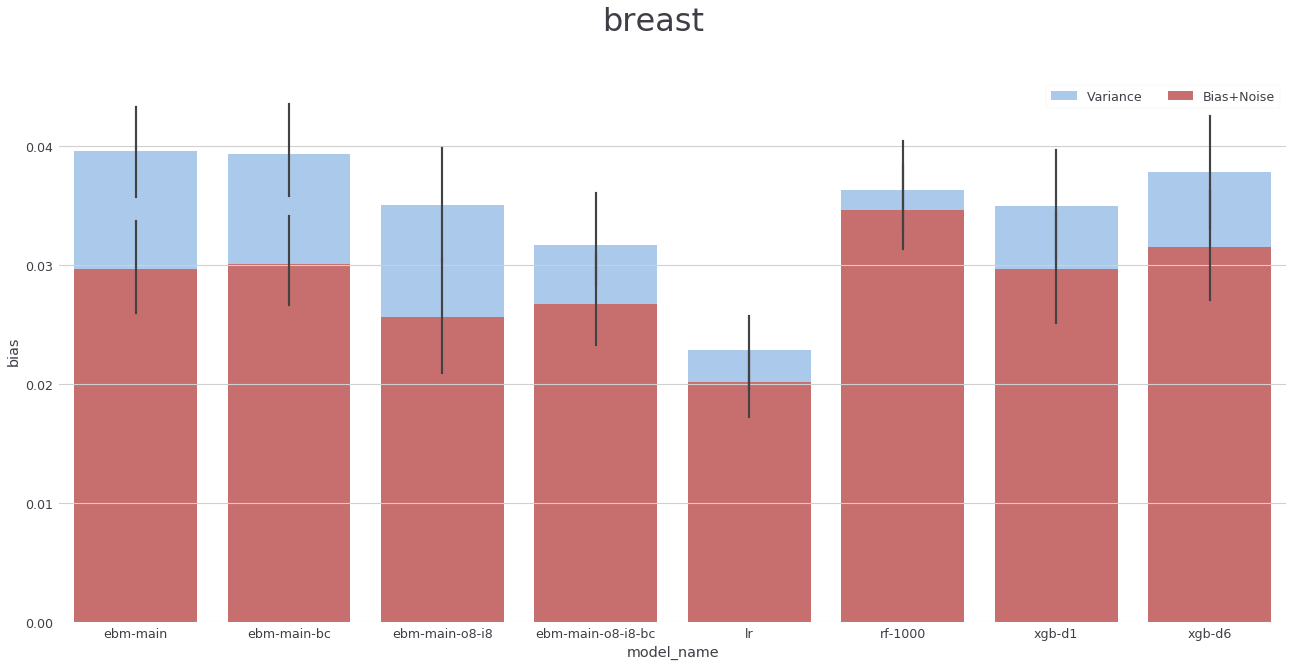

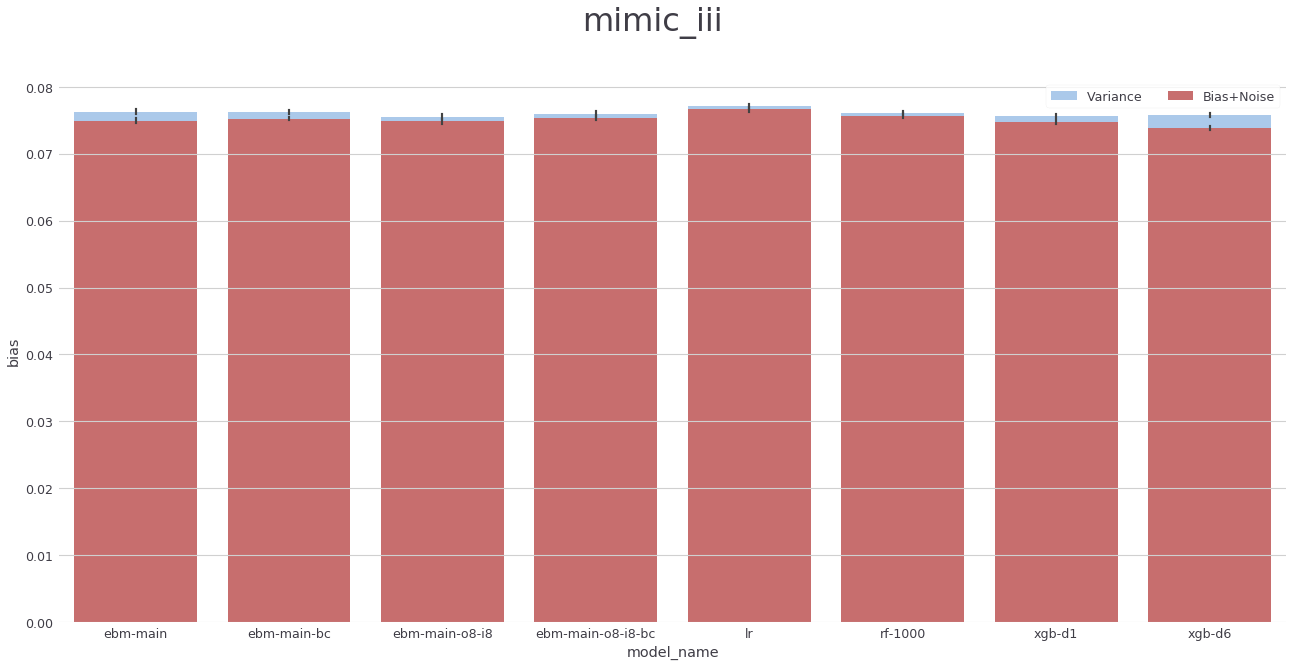

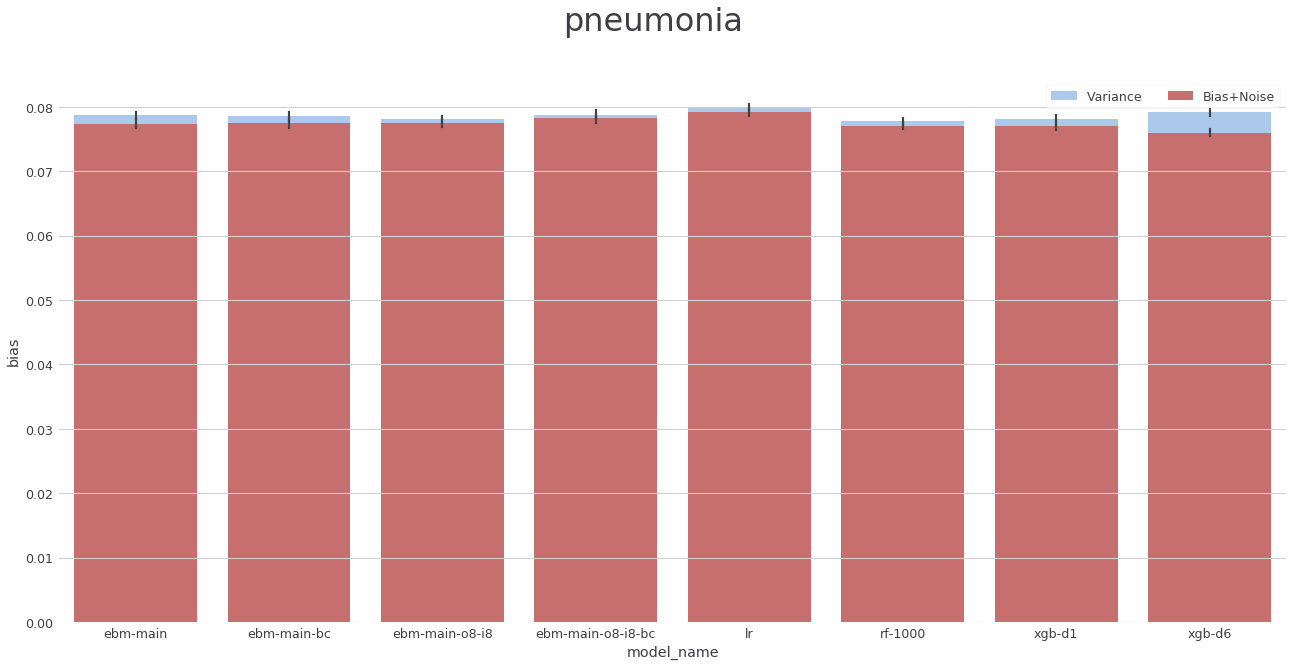

In [23]:
order = None
# order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['lr', 'dt', 'bagging-100', 'rf-10', 'rf-1000', 'xgb-d1', 'xgb-d2', 'xgb-d3', 'ebm-main', 'ebm-pair']
# order = ['lr', 'dt', 'bagging-100', 'rf-1000-d5', 'rf-1000-d10', 'rf-1000', 'xgb-d3', 'ebm-main', 'ebm-pair']


for name, group in summary_df.groupby('d_name'):
    fig, ax = plt.subplots(figsize=(22, 10))

    sns.set_color_codes("pastel")
    sns.barplot(x="model_name", y="error", data=group,
                label="Variance", color="b", order=order)

    sns.set_color_codes("muted")
    sns.barplot(x="model_name", y="bias", data=group,
                label="Bias+Noise", color="r", order=order)

    ax.legend(ncol=2, loc="best", frameon=True)

    sns.despine(left=True, bottom=True)

    fig.suptitle(name, fontsize=32)

# OLDDDDDD

In [ ]:
order = ['dt', 'bagging-10', 'bagging-25', 'bagging-100']
# order = ['rf-10', 'rf-50', 'rf-200', 'rf-500', 'rf-1000']
# order = ['dt', 'lr', 'rf-50', 'rf-1000', 'xgb-d1', 'xgb-d2', 'xgb-d3', 'ebm-main']

for name, group in summary_df.groupby('dataset_name'):
    fig, axes = plt.subplots(1, 4, figsize=(40, 10))
    
    sns.barplot(data=group, x='model_name', y='bias', ax=axes[0], order=order)    
    sns.barplot(data=group, x='model_name', y='variance', ax=axes[1], order=order)    
    sns.barplot(data=group, x='model_name', y='error', ax=axes[2], order=order)
    sns.barplot(data=group, x='model_name', y='auroc', ax=axes[3], order=order)
    axes[3].set_ylim(group.auroc.mean() - 0.1, 1.)

    fig.suptitle(name, fontsize=32)
